# Predicting California Property Close Price (Final Sales Price)

- **Dataset from**: datasets containing historical close price (final sales price) data on real estate properties sourced from CRMLS (California Regional Multiple Listing Service)

- **The project goal**: develop a machine-learning model to predict the close price of a particular property based on its characteristics

## The project steps

**1. Exploratory Data Analysis (EDA)**:
    
**2. Split the data into different sets**:

**3. Preprocess the data**: ML models only work if X and Y are numbers! Some ML models additionally require each feature to have 0 mean and 1 standard deviation (standardized features)
   - often the original features you get contain strings (for example a gender feature would contain 'male', 'female', 'non-binary', 'unknown') which needs to transformed into numbers
   - often the features are not standardized (e.g., age is between 0 and 100) but it need to be standardized
    
**4. Choose an evaluation metric**: depends on the priorities of the stakeholders
   - often requires quite a bit of thinking and ethical considerations
     
**5. Choose one or more ML techniques**: it is highly recommended that you try multiple models
   - start with simple models like linear or logistic regression
   - try also more complex models like nearest neighbors, support vector machines, random forest, etc.
    
**6. Tune the hyperparameters of your ML models (aka cross-validation)**
   - ML techniques have hyperparameters that you need to optimize to achieve best performance
   - for each ML model, decide which parameters to tune and what values to try
   - loop through each parameter combination
       - train one model for each parameter combination
       - evaluate how well the model performs on the validation set
   - take the parameter combo that gives the best validation score
   - evaluate that model on the test set to report how well the model is expected to perform on previously unseen data
    
**7. Interpret your model**: black boxes are often not useful
   - check if your model uses features that make sense (excellent tool for debugging)
   - often model predictions are not enough, you need to be able to explain how the model arrived to a particular prediction (e.g., in health care)

## Package and dataset


In [5]:
# pip install basemap basemap-data-hires

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1030_project/ca_colse_price_prediction_data.csv')

## Exploratory Data Analysis (EDA)

### basic information checking

In [9]:
df = data

In [10]:
df.shape

(50174, 27)

In [11]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50174 entries, 0 to 50173
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Flooring                     30165 non-null  object 
 1   ViewYN                       37887 non-null  object 
 2   PoolPrivateYN                41306 non-null  object 
 3   ListingKey                   50174 non-null  int64  
 4   CloseDate                    50174 non-null  object 
 5   ClosePrice                   50174 non-null  float64
 6   Latitude                     50152 non-null  float64
 7   Longitude                    50152 non-null  float64
 8   PropertyType                 50174 non-null  object 
 9   LivingArea                   50117 non-null  float64
 10  ListPrice                    50174 non-null  float64
 11  DaysOnMarket                 50174 non-null  int64  
 12  AssociationFeeFrequency      10169 non-null  object 
 13  AttachedGarageYN

In [12]:
missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_data_df = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage (%)': missing_percentage
})
print(missing_data_df)

                             Missing Values  Percentage (%)
Flooring                              20009       39.879220
ViewYN                                12287       24.488779
PoolPrivateYN                          8868       17.674493
ListingKey                                0        0.000000
CloseDate                                 0        0.000000
ClosePrice                                0        0.000000
Latitude                                 22        0.043847
Longitude                                22        0.043847
PropertyType                              0        0.000000
LivingArea                               57        0.113605
ListPrice                                 0        0.000000
DaysOnMarket                              0        0.000000
AssociationFeeFrequency               40005       79.732531
AttachedGarageYN                       8445       16.831427
PropertySubType                           0        0.000000
LotSizeAcres                           2

In [13]:
no_missing = missing_data_df[missing_data_df['Percentage (%)'] == 0].index.tolist()
low_missing = missing_data_df[(missing_data_df['Percentage (%)'] > 0) & (missing_data_df['Percentage (%)'] <= 40)].index.tolist()
high_missing = missing_data_df[missing_data_df['Percentage (%)'] > 40].index.tolist()

print(f"No missing value columns: {no_missing}")
print('------------------------------------------------------------------------------------------------')
print(f"Low missing value columns: {low_missing}")
print('------------------------------------------------------------------------------------------------')
print(f"High missing value columns: {high_missing}")
print('------------------------------------------------------------------------------------------------')


No missing value columns: ['ListingKey', 'CloseDate', 'ClosePrice', 'PropertyType', 'ListPrice', 'DaysOnMarket', 'PropertySubType', 'City', 'BedroomsTotal', 'StateOrProvince']
------------------------------------------------------------------------------------------------
Low missing value columns: ['Flooring', 'ViewYN', 'PoolPrivateYN', 'Latitude', 'Longitude', 'LivingArea', 'AttachedGarageYN', 'LotSizeAcres', 'YearBuilt', 'BuyerAgencyCompensationType', 'BathroomsTotalInteger', 'FireplaceYN', 'Stories', 'Levels', 'NewConstructionYN', 'PostalCode']
------------------------------------------------------------------------------------------------
High missing value columns: ['AssociationFeeFrequency']
------------------------------------------------------------------------------------------------


#### StateOrProvince(drop)

In [14]:
df['StateOrProvince'].value_counts()

,count
StateOrProvince,
CA,50174


In [15]:
# Drop column, totally unique only CA like id
df = df.drop(columns=['StateOrProvince'])

#### Flooring

In [16]:
(df['Flooring'].isnull().sum() / len(df)) * 100

39.87922031330968

In [17]:
print(df['Flooring'].head(3))

0         SeeRemarks,Tile
1               Tile,Wood
2    Carpet,Laminate,Tile
Name: Flooring, dtype: object


In [18]:
print(df['Flooring'].value_counts().head(10))

Flooring
Wood                    4237
Tile,Wood               4048
Carpet,Tile             2992
Laminate                2138
Carpet,Tile,Wood        2090
Laminate,Tile           1491
Tile                    1443
Carpet,Wood             1359
Carpet,Laminate         1280
Carpet,Laminate,Tile    1261
Name: count, dtype: int64


In [19]:
df['Flooring'].fillna('unknown', inplace=True)

<ipython-input-19-d4df88f50e46>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Flooring'].fillna('unknown', inplace=True)


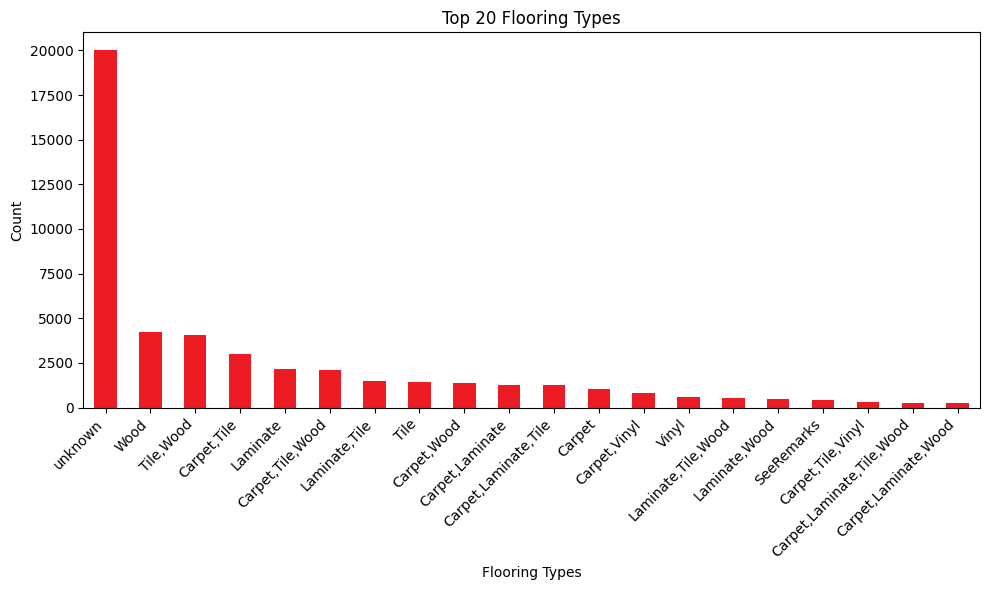

In [20]:
flooring_counts = df['Flooring'].value_counts()
top_20_flooring = flooring_counts.head(20)

plt.figure(figsize=(10, 6))
top_20_flooring.plot(kind='bar', color='#ED1C24')
plt.title('Top 20 Flooring Types')
plt.xlabel('Flooring Types')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### 'ViewYN' & 'PoolPrivateYN'

In [21]:
view_missing_percent = (df['ViewYN'].isnull().sum() / len(df)) * 100
pool_missing_percent = (df['PoolPrivateYN'].isnull().sum() / len(df)) * 100

(view_missing_percent, pool_missing_percent)


(24.488779048909795, 17.67449276517718)

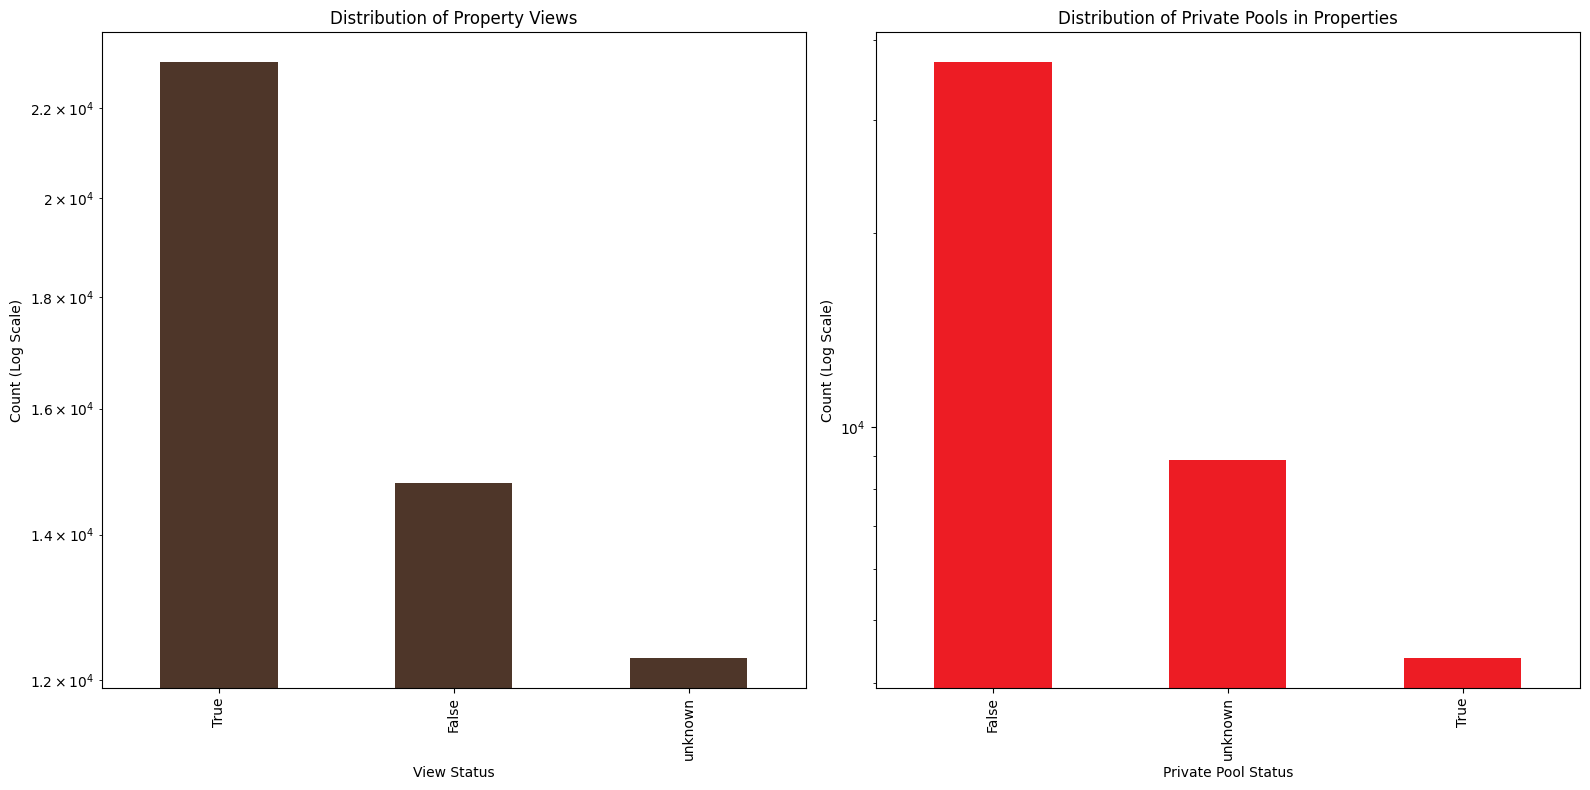

In [22]:
df[['ViewYN', 'PoolPrivateYN']] = df[['ViewYN', 'PoolPrivateYN']].fillna('unknown')

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

df['ViewYN'].value_counts().plot(kind='bar', ax=axs[0], color='#4E3629', logy=True)
axs[0].set_title('Distribution of Property Views')
axs[0].set_xlabel('View Status')
axs[0].set_ylabel('Count (Log Scale)')

df['PoolPrivateYN'].value_counts().plot(kind='bar', ax=axs[1], color='#ED1C24', logy=True)
axs[1].set_title('Distribution of Private Pools in Properties')
axs[1].set_xlabel('Private Pool Status')
axs[1].set_ylabel('Count (Log Scale)')

plt.tight_layout()
plt.show()


####  ListingKey (Drop)

In [23]:
df['ListingKey'].nunique(), df.shape

(50174, (50174, 26))

In [24]:
df.drop(columns=['ListingKey'], inplace=True)

ListingKey are unique, so I drop here

#### CloseDate

In [25]:
(df['CloseDate'].isnull().sum() / len(df)) * 100

0.0

In [26]:
df['CloseDate'].min(), df['CloseDate'].max()

('2022-01-02', '2023-12-31')

In [27]:
jan_2022_data = df[(df['CloseDate'] >= '2022-01-01') & (df['CloseDate'] < '2022-02-01')]

jan_2022_count = jan_2022_data.shape[0]
jan_2022_count

2121

In [28]:
jan_2023_data = df[(df['CloseDate'] >= '2023-01-01') & (df['CloseDate'] < '2023-02-01')]

jan_2023_data = jan_2023_data.shape[0]
jan_2023_data

1302

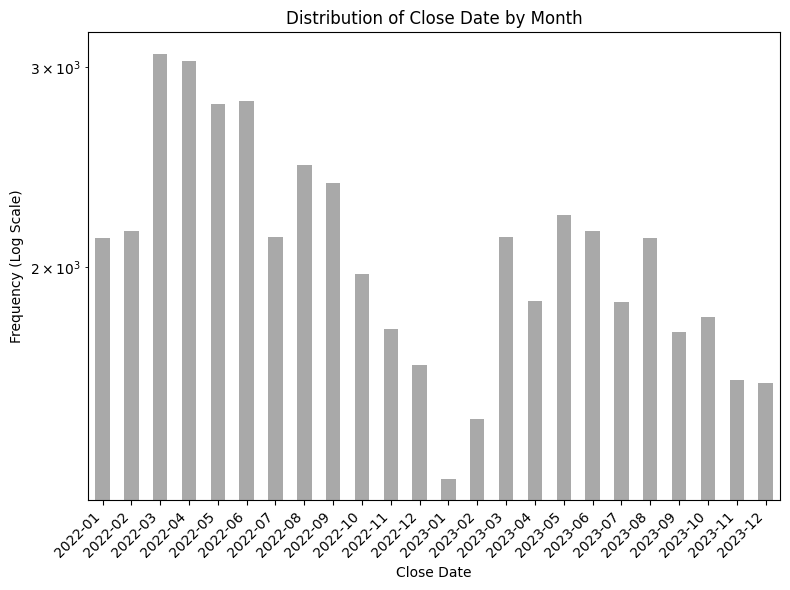

In [29]:
df['CloseDate'] = pd.to_datetime(df['CloseDate'], errors='coerce')
df['CloseDate_Month'] = df['CloseDate'].dt.to_period('M')

plt.figure(figsize=(8, 6))
df['CloseDate_Month'].value_counts().sort_index().plot(kind='bar', color='darkgray', logy=True)
plt.title('Distribution of Close Date by Month')
plt.xlabel('Close Date')
plt.ylabel('Frequency (Log Scale)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### ClosePrice

In [30]:
(df['ClosePrice'].isnull().sum() / len(df)) * 100

0.0

In [31]:
df['ClosePrice'].describe()

,ClosePrice
count,5.017400e+04
mean,1.197168e+06
std,1.410282e+06
min,1.600000e+04
25%,5.800000e+05
50%,8.752500e+05
75%,1.485000e+06
max,1.410000e+08


`ListPrice` is 659000.0, but the `ClosePrice` is 659.0. That is a mistake, so I drop it.

In [32]:
df['ClosePrice'].min()

16000.0

In [33]:
df[df['ClosePrice'] == df['ClosePrice'].min()]

,Flooring,ViewYN,PoolPrivateYN,CloseDate,ClosePrice,Latitude,Longitude,PropertyType,LivingArea,ListPrice,...,BuyerAgencyCompensationType,BathroomsTotalInteger,City,BedroomsTotal,FireplaceYN,Stories,Levels,NewConstructionYN,PostalCode,CloseDate_Month
16128,Vinyl,True,False,2023-09-01,16000.0,33.546182,-117.159311,Residential,2701.0,1580000.0,...,Item1,3.0,Murrieta,5.0,True,1.0,One,False,92563,2023-09


ClosePrice is 16000.0, and List Price is 1580000.0, which is unreasonable for LivingArea is 2701 sqft

In [34]:
df = df[df['ClosePrice'] != 16000.0]

In [35]:
df['ClosePrice'].max()

141000000.0

In [36]:
df[df['ClosePrice'] == df['ClosePrice'].max()]

,Flooring,ViewYN,PoolPrivateYN,CloseDate,ClosePrice,Latitude,Longitude,PropertyType,LivingArea,ListPrice,...,BuyerAgencyCompensationType,BathroomsTotalInteger,City,BedroomsTotal,FireplaceYN,Stories,Levels,NewConstructionYN,PostalCode,CloseDate_Month
46928,"Carpet,Stone",True,True,2022-03-30,141000000.0,34.088355,-118.451663,Residential,105000.0,295000000.0,...,Item1,49.0,Los Angeles,21.0,True,NaN,NaN,False,90077,2022-03


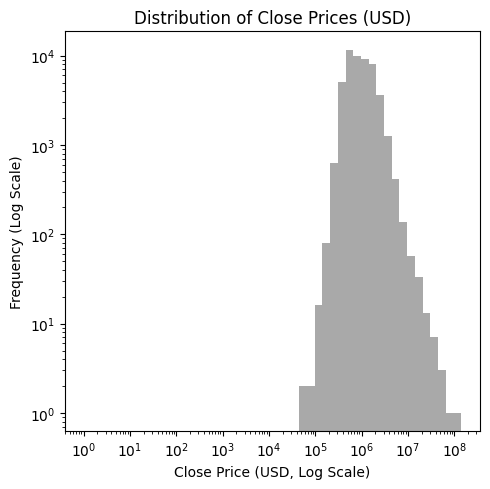

In [37]:
plt.figure(figsize=(5,5))

bins = np.logspace(np.log10(1), np.log10(np.max(df['ClosePrice'])), 50)
df['ClosePrice'].plot.hist(bins=bins, log=True, color='darkgray')

plt.semilogx()
plt.semilogy()
plt.title('Distribution of Close Prices (USD)')
plt.xlabel('Close Price (USD, Log Scale)')
plt.ylabel('Frequency (Log Scale)')
plt.tight_layout()
plt.show()

#### Longitude & Latitude

In [38]:
df['Longitude'].isnull().sum(), df['Latitude'].isnull().sum()

(22, 22)

In [39]:
df.shape

(50173, 26)

In [40]:
california_longitude_range = (-124.26, -114.13)
california_latitude_range = (32.53, 42.00)

In [41]:
df = df[
    ((df['Longitude'] >= california_longitude_range[0]) & (df['Longitude'] <= california_longitude_range[1]) &
    ((df['Latitude'] >= california_latitude_range[0]) & (df['Latitude'] <= california_latitude_range[1])))
]
df.shape

(50147, 26)

In [42]:
city_name = df['City'].value_counts()
city_name

,count
City,
Los Angeles,10803
San Diego,9937
San Jose,7686
Riverside,4850
Oakland,3965
Menifee,3480
Victorville,3377
Hemet,3026
Murrieta,3023


In [43]:
# coords = {
#     "Los Angeles": (34.052235, -118.243683),
#     "San Diego": (32.715736, -117.161087),
#     "San Jose": (37.335480, -121.893028),
#     "Riverside": (33.980600, -117.375494),
#     "Oakland": (37.804363, -122.271111),
#     "Menifee": (33.697147, -117.185294),
#     "Victorville": (34.536218, -117.292764),
#     "Hemet": (33.747520, -116.971968),
#     "Murrieta": (33.553914, -117.213923)
# }
#
# plt.figure(figsize=(12, 10))
# m = Basemap(projection='merc',
#             llcrnrlat=32.53, urcrnrlat=42,
#             llcrnrlon=-124.26, urcrnrlon=-114.13,
#             resolution='i')
# m.drawcoastlines()
# m.drawcountries()
# m.drawstates()
#
# x, y = m(df['Longitude'].values, df['Latitude'].values)
# m.scatter(x, y, color='darkgray', alpha=0.5, marker='o')
#
# for city, (lat, lon) in coords.items():
#     x, y = m(lon, lat)
#     m.plot(x, y, marker='o', color='blue', markersize=8)
#
#     if city in ["Hemet", "Riverside"]:
#         plt.text(x + 10000, y, city, fontsize=10, fontweight='bold',
#                  ha='left', va='bottom', color='blue', alpha=0.8)
#     elif city in ["Murrieta", "Menifee"]:
#         plt.text(x + 20000, y - 30000, city, fontsize=10, fontweight='bold',
#                  ha='left', va='bottom', color='blue', alpha=0.8)
#     else:
#         plt.text(x, y - 10000, city, fontsize=10, fontweight='bold',
#                  ha='center', va='top', color='blue', alpha=0.8)
#
# plt.title('Geographical Distribution of Housing in California')
# plt.show()

#### PropertyType(drop)

Only one PropertyType, so I drop

In [44]:
df['PropertyType'].value_counts()

,count
PropertyType,
Residential,50147


In [45]:
df = df.drop(columns=['PropertyType'])

#### LivingArea

In [46]:
df['LivingArea'].isnull().sum(), df.shape

(57, (50147, 25))

In [47]:
negative_living_area_count = (df['LivingArea'] <= 0).sum()
negative_living_area_count

42

In [48]:
# LivingArea must greater than 1 sq ft
df = df[(df['LivingArea'] > 1) | df['LivingArea'].isna()]
df.shape

(50105, 25)

In [49]:
df['LivingArea'].describe()

,LivingArea
count,50048.000000
mean,1929.694014
std,1093.100561
min,100.000000
25%,1304.000000
50%,1713.000000
75%,2296.000000
max,105000.000000


Can't have a bedroom in a 100 sqft house and their `LotSizeArea` is so big, so I drop it

In [50]:
df[df['LivingArea'] == 100]

,Flooring,ViewYN,PoolPrivateYN,CloseDate,ClosePrice,Latitude,Longitude,LivingArea,ListPrice,DaysOnMarket,...,BuyerAgencyCompensationType,BathroomsTotalInteger,City,BedroomsTotal,FireplaceYN,Stories,Levels,NewConstructionYN,PostalCode,CloseDate_Month
830,unknown,True,False,2022-04-06,2000000.0,33.545359,-117.219989,100.0,1999999.0,249,...,Item1,0.0,Murrieta,0.0,False,1.0,One,False,92562,2022-04


In [51]:
df = df[df['LivingArea'] != 100]

In [52]:
df['LivingArea'].max()

105000.0

In [53]:
df[df['LivingArea'] == 105000.0]

,Flooring,ViewYN,PoolPrivateYN,CloseDate,ClosePrice,Latitude,Longitude,LivingArea,ListPrice,DaysOnMarket,...,BuyerAgencyCompensationType,BathroomsTotalInteger,City,BedroomsTotal,FireplaceYN,Stories,Levels,NewConstructionYN,PostalCode,CloseDate_Month
46928,"Carpet,Stone",True,True,2022-03-30,141000000.0,34.088355,-118.451663,105000.0,295000000.0,79,...,Item1,49.0,Los Angeles,21.0,True,NaN,NaN,False,90077,2022-03


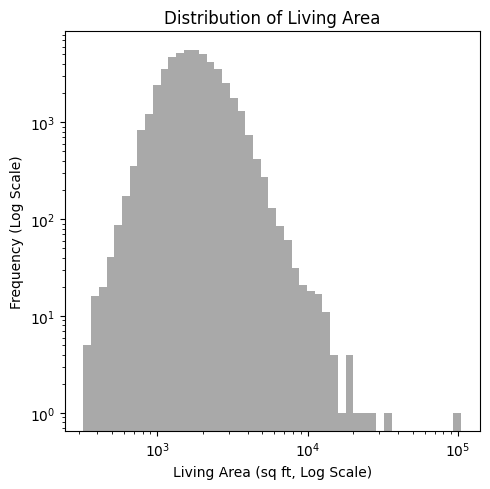

In [54]:
plt.figure(figsize=(5,5))
living_area = df['LivingArea'].dropna()
bins = np.logspace(np.log10(living_area.min()), np.log10(living_area.max()), 50)

plt.hist(living_area, bins=bins, color='darkgray', log=True)


plt.xscale('log')
plt.title('Distribution of Living Area')
plt.xlabel('Living Area (sq ft, Log Scale)')
plt.ylabel('Frequency (Log Scale)')

plt.tight_layout()
plt.show()

#### ListPrice

In [55]:
negative_check = df[df['ListPrice'] < 0]

negative_check

,Flooring,ViewYN,PoolPrivateYN,CloseDate,ClosePrice,Latitude,Longitude,LivingArea,ListPrice,DaysOnMarket,...,BuyerAgencyCompensationType,BathroomsTotalInteger,City,BedroomsTotal,FireplaceYN,Stories,Levels,NewConstructionYN,PostalCode,CloseDate_Month


In [56]:
df['ListPrice'].min()

450.0

This record should be deleted due to the unrealistic OriginalListPrice of 450.0, which does not align with the LivingArea and LotSizeAcres.

In [57]:
df[df['ListPrice'] == 450.0]

,Flooring,ViewYN,PoolPrivateYN,CloseDate,ClosePrice,Latitude,Longitude,LivingArea,ListPrice,DaysOnMarket,...,BuyerAgencyCompensationType,BathroomsTotalInteger,City,BedroomsTotal,FireplaceYN,Stories,Levels,NewConstructionYN,PostalCode,CloseDate_Month
1822,unknown,False,False,2023-10-24,450000.0,33.899174,-117.462269,1000.0,450.0,0,...,Item1,2.0,Riverside,3.0,True,1.0,One,False,92503,2023-10


In [58]:
df = df[df['ListPrice'] != 450.0]

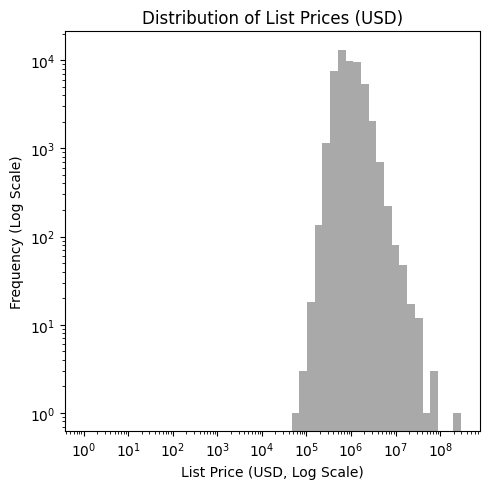

In [59]:
plt.figure(figsize=(5,5))

bins = np.logspace(np.log10(1), np.log10(np.max(df['ListPrice'])), 50)
df['ListPrice'].plot.hist(bins=bins, log=True, color='darkgray')

plt.semilogx()
plt.semilogy()
plt.title('Distribution of List Prices (USD)')
plt.xlabel('List Price (USD, Log Scale)')
plt.ylabel('Frequency (Log Scale)')
plt.tight_layout()
plt.show()

#### DaysOnMarket

In [60]:
negative_days_on_market = df[df['DaysOnMarket'] <= 0]

negative_days_on_market.head(10)

,Flooring,ViewYN,PoolPrivateYN,CloseDate,ClosePrice,Latitude,Longitude,LivingArea,ListPrice,DaysOnMarket,...,BuyerAgencyCompensationType,BathroomsTotalInteger,City,BedroomsTotal,FireplaceYN,Stories,Levels,NewConstructionYN,PostalCode,CloseDate_Month
20,unknown,False,False,2022-05-20,335000.0,34.493929,-117.375512,1650.0,335000.0,0,...,Item1,3.0,Victorville,4.0,True,1.0,One,False,92392,2022-05
127,"Carpet,Vinyl",True,False,2022-01-13,350000.0,33.733732,-116.941984,1905.0,350000.0,0,...,Item1,4.0,Hemet,3.0,True,1.0,One,False,92544,2022-01
252,unknown,False,False,2022-06-09,675000.0,34.010559,-118.314486,1376.0,679900.0,0,...,Item1,2.0,Los Angeles,3.0,False,1.0,One,False,90062,2022-06
306,unknown,False,False,2022-09-13,455000.0,32.706140,-117.033834,964.0,450000.0,0,...,Item1,2.0,San Diego,3.0,False,1.0,One,NaN,92114,2022-09
486,"Tile,Wood",True,False,2022-03-04,1520000.0,34.104226,-118.316633,1677.0,1520000.0,0,...,Item1,3.0,Los Angeles,2.0,False,NaN,NaN,False,90028,2022-03
514,unknown,unknown,False,2022-01-12,625000.0,32.581094,-117.047663,1511.0,625000.0,0,...,Item1,2.0,San Diego,4.0,NaN,1.0,One,NaN,92154,2022-01
656,unknown,False,False,2022-03-07,470000.0,34.006783,-118.275730,1168.0,495000.0,0,...,Item1,1.0,Los Angeles,2.0,False,1.0,One,False,90037,2022-03
697,unknown,False,False,2022-07-08,303000.0,33.938971,-118.257077,1070.0,320000.0,0,...,Item1,1.0,Los Angeles,3.0,False,1.0,One,False,90002,2022-07
700,unknown,unknown,False,2022-01-19,390000.0,33.940923,-118.241999,804.0,430000.0,0,...,Item1,1.0,Los Angeles,2.0,NaN,1.0,One,NaN,90002,2022-01
767,Wood,True,False,2022-01-21,350000.0,33.980372,-117.384301,891.0,350000.0,0,...,Item1,1.0,Riverside,2.0,False,1.0,One,False,92501,2022-01


In [61]:
df['DaysOnMarket'].isnull().sum()

0

In [62]:
# DaysOnMarket cannot be neg
df = df[(df['DaysOnMarket'] >= 0)]
df.shape

(50089, 25)

In [63]:
df['DaysOnMarket'].describe()

,DaysOnMarket
count,50089.000000
mean,26.089161
std,38.450053
min,0.000000
25%,7.000000
50%,13.000000
75%,30.000000
max,1082.000000


#### AssociationFeeFrequency

In [64]:
df['AssociationFeeFrequency'].fillna('unknown', inplace=True)
df['AssociationFeeFrequency'].value_counts()

<ipython-input-64-00c2c548df0d>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['AssociationFeeFrequency'].fillna('unknown', inplace=True)
<ipython-input-64-00c2c548df0d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AssociationFeeFrequency'].fillna('unknown', inplace=True)


,count
AssociationFeeFrequency,
unknown,39929
Monthly,8290
Annually,1558
Quarterly,301
SemiAnnually,11


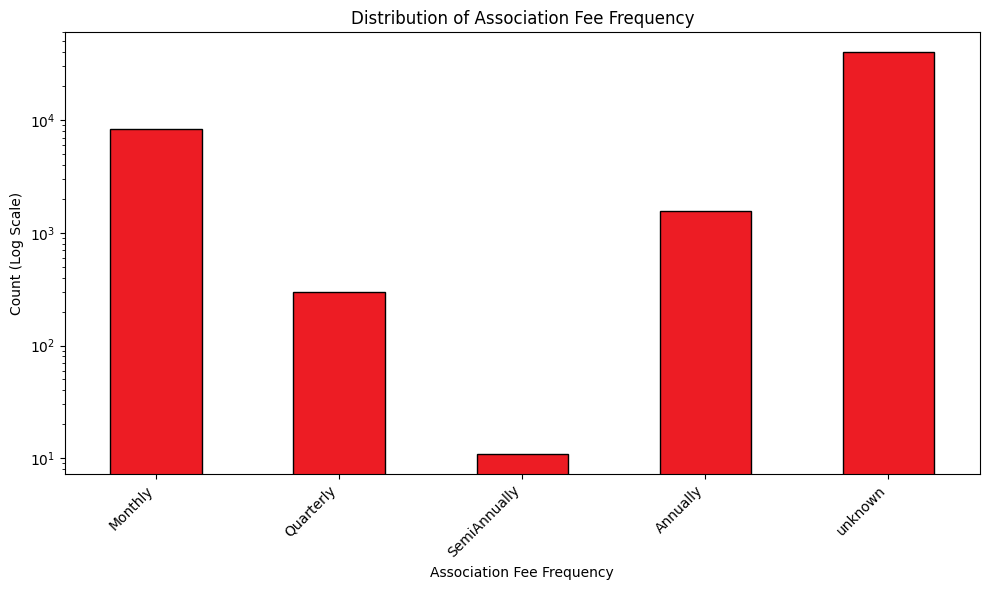

In [65]:
order = ['Monthly', 'Quarterly', 'SemiAnnually', 'Annually', 'unknown']
counts = df['AssociationFeeFrequency'].value_counts().reindex(order)

plt.figure(figsize=(10, 6))
counts.plot(kind='bar', color='#ED1C24', edgecolor='black', logy=True)

plt.title('Distribution of Association Fee Frequency')
plt.xlabel('Association Fee Frequency')
plt.ylabel('Count (Log Scale)')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

#### AttachedGarageYN

In [66]:
df['AttachedGarageYN'] = df['AttachedGarageYN'].fillna('unknown')

In [67]:
df['AttachedGarageYN'].value_counts()

,count
AttachedGarageYN,
True,33194
False,8485
unknown,8410


In [68]:
unknown_count = df['AttachedGarageYN'].value_counts().get('unknown', 0)
total_count = df['AttachedGarageYN'].shape[0]
unknown_percentage = (unknown_count / total_count) * 100

unknown_percentage

16.790113597795923

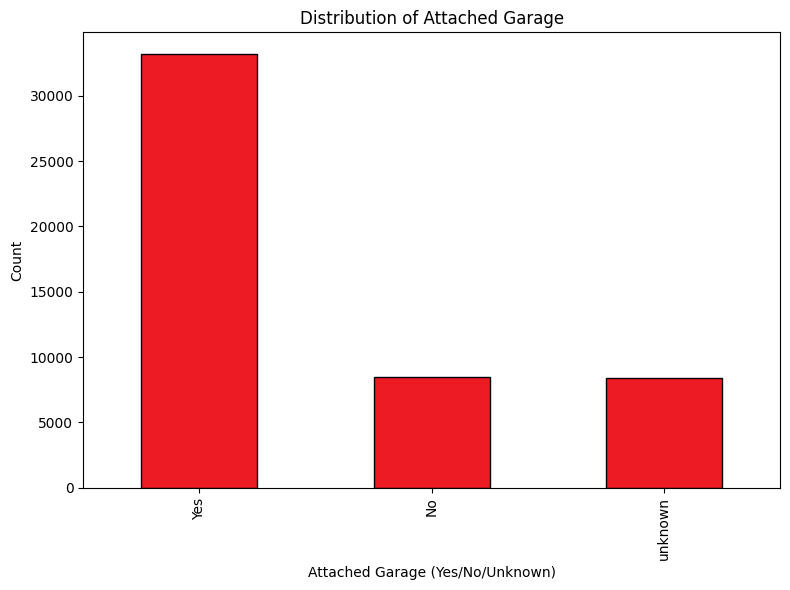

In [69]:
df['AttachedGarageYN'] = df['AttachedGarageYN'].map({True: 'Yes', False: 'No', 'unknown': 'unknown'})

plt.figure(figsize=(8, 6))
df['AttachedGarageYN'].value_counts().plot(kind='bar', color='#ED1C24', edgecolor='black')
plt.title('Distribution of Attached Garage')
plt.xlabel('Attached Garage (Yes/No/Unknown)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### PropertySubType(drop)

In [70]:
df['PropertySubType'] = df['PropertySubType'].fillna('unknown')

In [71]:
df['PropertySubType'].value_counts()

,count
PropertySubType,
SingleFamilyResidence,50089


Drop column, totally unique like id

In [72]:
df.drop(columns=['PropertySubType'], inplace=True)

#### LotSizeAcres

In [73]:
df['LotSizeAcres'].describe()

,LotSizeAcres
count,47969.000000
mean,4.439880
std,456.206414
min,0.000000
25%,0.123300
50%,0.152500
75%,0.190000
max,91040.000000


I am filtering the data to include only properties with a LotSizeAcres below 1,000, as any value above this threshold is unrealistic for a single-family residence and likely represents a data error or anomaly.

In [74]:
df.shape

(50089, 24)

In [75]:
df = df[(df['LotSizeAcres'] < 1000) & (df['LotSizeAcres'] > 0) | (df['LotSizeAcres'].isna())]

In [76]:
df.shape

(50041, 24)

In [77]:
df['LotSizeAcres'].describe()

,LotSizeAcres
count,47921.000000
mean,0.262319
std,1.083744
min,0.000200
25%,0.123400
50%,0.152500
75%,0.190000
max,82.170000


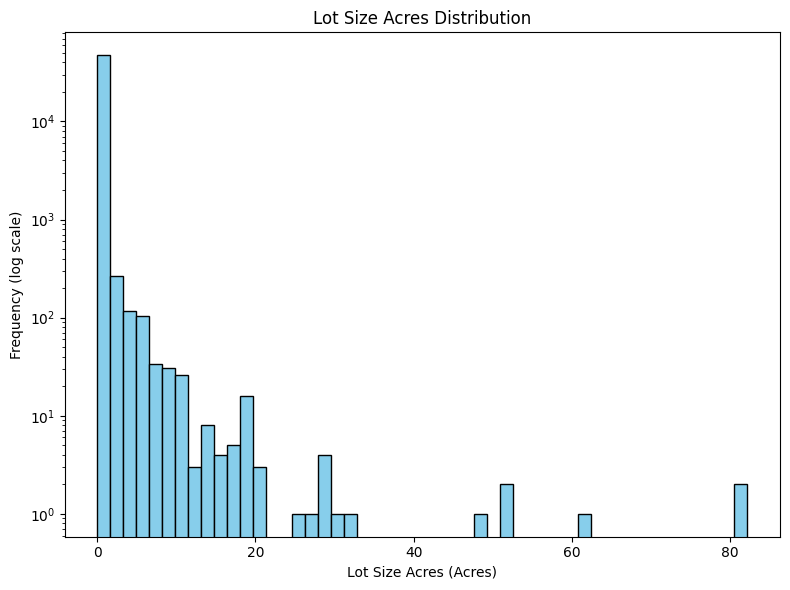

In [78]:
lot_size_acres = df['LotSizeAcres'].dropna()

plt.figure(figsize=(8, 6))
plt.hist(lot_size_acres, bins=50, color='skyblue', edgecolor='black')
plt.yscale('log')
plt.title('Lot Size Acres Distribution')
plt.xlabel('Lot Size Acres (Acres)')
plt.ylabel('Frequency (log scale)')
plt.tight_layout()
plt.show()

#### YearBuilt

In [79]:
df['YearBuilt'].describe()

,YearBuilt
count,49976.000000
mean,1968.662698
std,31.567935
min,1850.000000
25%,1947.000000
50%,1968.000000
75%,1995.000000
max,2024.000000


In [80]:
df['YearBuilt'].isnull().sum()

65

In [81]:
df[df['YearBuilt'] == 1850]

,Flooring,ViewYN,PoolPrivateYN,CloseDate,ClosePrice,Latitude,Longitude,LivingArea,ListPrice,DaysOnMarket,...,BuyerAgencyCompensationType,BathroomsTotalInteger,City,BedroomsTotal,FireplaceYN,Stories,Levels,NewConstructionYN,PostalCode,CloseDate_Month
39161,unknown,True,unknown,2022-07-22,1378888.0,37.36843,-121.79983,896.0,1488888.0,10,...,Item1,1.0,San Jose,2.0,True,NaN,NaN,False,95127,2022-07


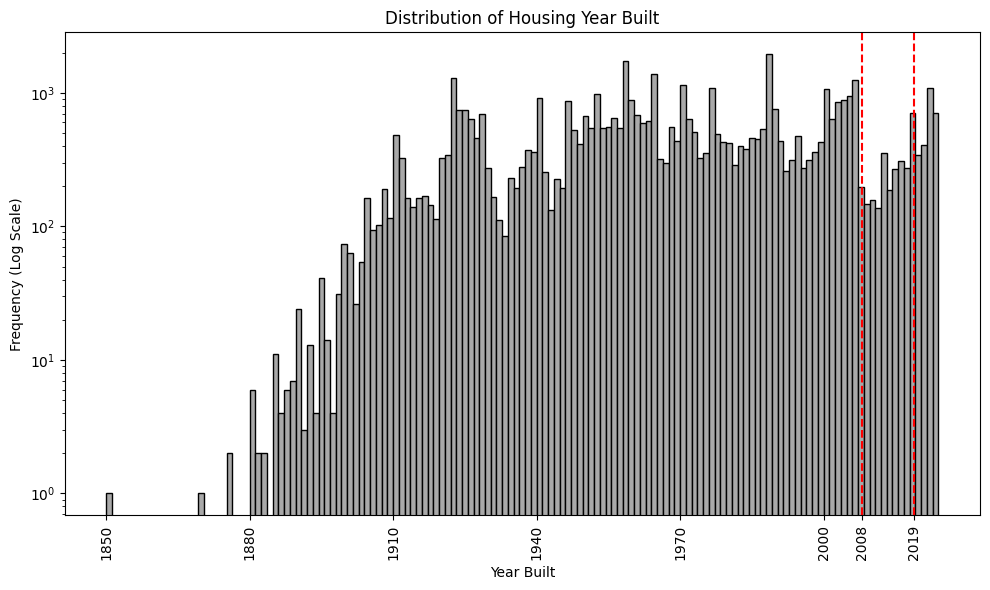

In [82]:
plt.figure(figsize=(10, 6))

df['YearBuilt'].dropna().astype(int).plot(kind='hist', bins=df['YearBuilt'].nunique(),
                                          color='darkgrey', edgecolor='black', log=True)
plt.axvline(2019, color='red', linestyle='--', linewidth=1.5, label='Year 2019')
plt.axvline(2008, color='red', linestyle='--', linewidth=1.5, label='Year 2008')

xticks = list(range(1850, 2025, 30)) + [2008, 2019]
plt.xticks(xticks, rotation=90)

plt.title('Distribution of Housing Year Built')
plt.xlabel('Year Built')
plt.ylabel('Frequency (Log Scale)')
plt.tight_layout()
plt.show()


#### BuyerAgencyCompensationType

In [83]:
df['BuyerAgencyCompensationType'] = df['BuyerAgencyCompensationType'].fillna('unknown')

In [84]:
df['BuyerAgencyCompensationType'].value_counts()

,count
BuyerAgencyCompensationType,
Item1,49661
Item,367
SeeRemarks,12
unknown,1


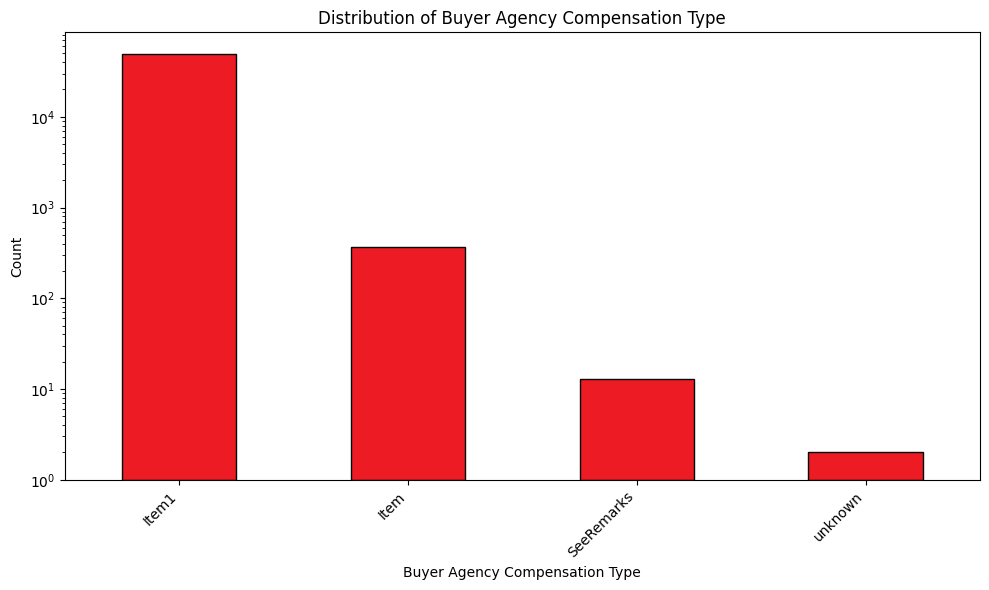

In [85]:
plt.figure(figsize=(10, 6))
df['BuyerAgencyCompensationType'].value_counts().plot(kind='bar', color='#ED1C24', edgecolor='black', log = True)
plt.title('Distribution of Buyer Agency Compensation Type')
plt.xlabel('Buyer Agency Compensation Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### BathroomsTotalInteger

In [86]:
df['BathroomsTotalInteger'].isnull().sum(),df.shape[0]

(14, 50041)

In [87]:
df['BathroomsTotalInteger'].describe()

,BathroomsTotalInteger
count,50027.000000
mean,2.496312
std,1.088129
min,0.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,49.000000


In [88]:
filtered_df = df[df['BathroomsTotalInteger'].isin([49.0])]

filtered_df

,Flooring,ViewYN,PoolPrivateYN,CloseDate,ClosePrice,Latitude,Longitude,LivingArea,ListPrice,DaysOnMarket,...,BuyerAgencyCompensationType,BathroomsTotalInteger,City,BedroomsTotal,FireplaceYN,Stories,Levels,NewConstructionYN,PostalCode,CloseDate_Month
46928,"Carpet,Stone",True,True,2022-03-30,141000000.0,34.088355,-118.451663,105000.0,295000000.0,79,...,Item1,49.0,Los Angeles,21.0,True,NaN,NaN,False,90077,2022-03


In [89]:
filtered_df = df[df['BathroomsTotalInteger'].isin([0])]

filtered_df.shape

(12, 24)

In [90]:
df.shape

(50041, 24)

In [91]:
# It's almost impossible for a residents house have 0 bathrooms
df = df[~df['BathroomsTotalInteger'].isin([0])]

df.shape

(50029, 24)

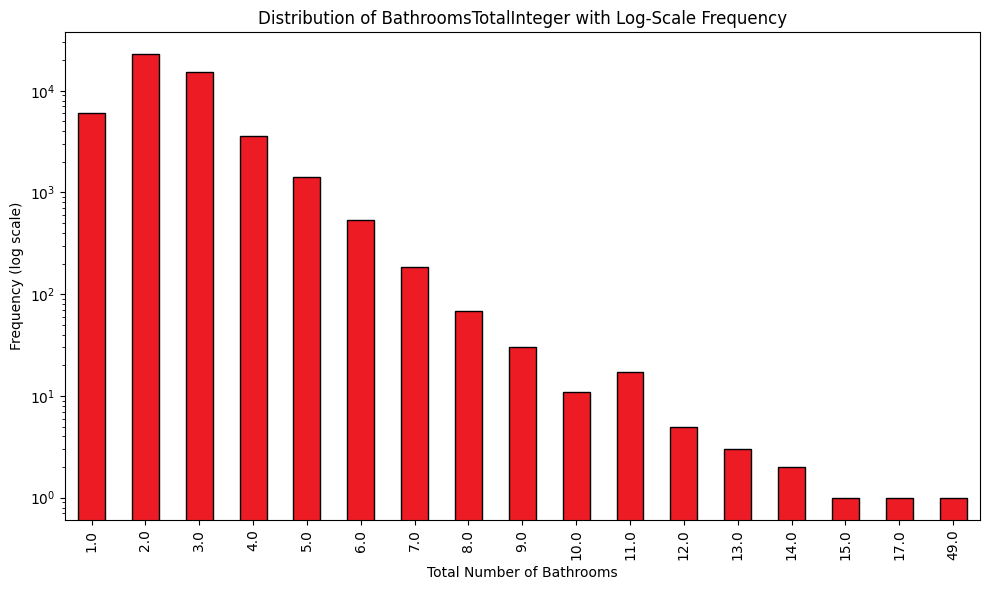

In [92]:
bathrooms_counts = df['BathroomsTotalInteger'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bathrooms_counts.plot(kind='bar',  color='#ED1C24', edgecolor='black', logy=True)
plt.title('Distribution of BathroomsTotalInteger with Log-Scale Frequency')
plt.xlabel('Total Number of Bathrooms')
plt.ylabel('Frequency (log scale)')
plt.tight_layout()
plt.show()

#### City

In [93]:
df['City'].value_counts()

,count
City,
Los Angeles,10748
San Diego,9904
San Jose,7686
Riverside,4843
Oakland,3954
Menifee,3478
Victorville,3372
Hemet,3023
Murrieta,3021


In [94]:
df['City'] = df['City'].fillna('unknown')

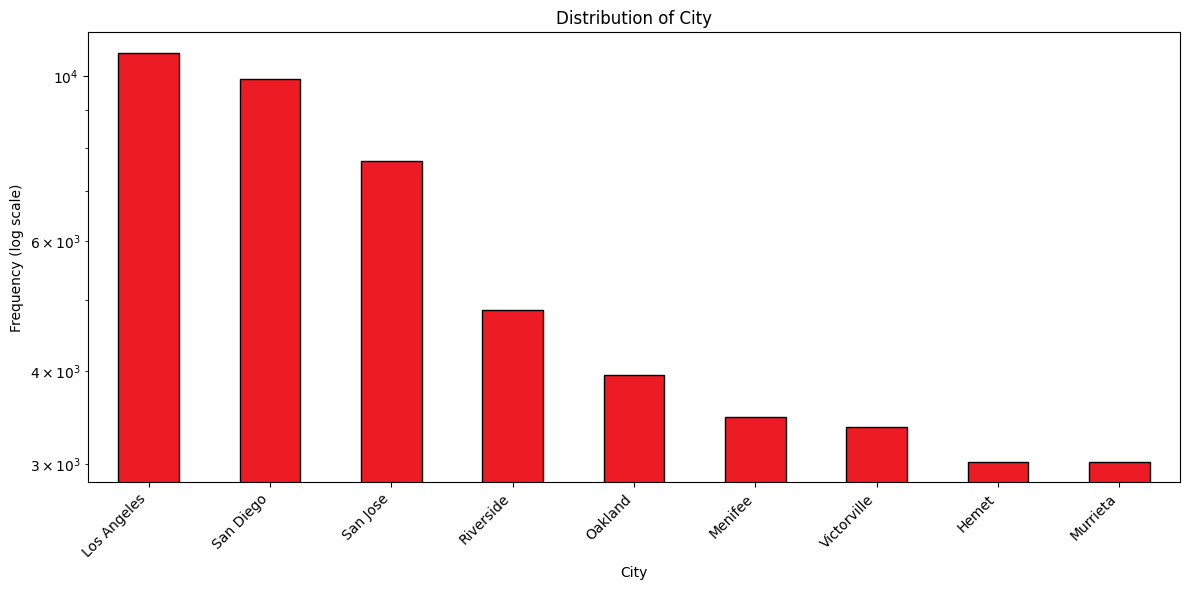

In [95]:
city_counts = df['City'].value_counts().head(25)

plt.figure(figsize=(12, 6))
city_counts.plot(kind='bar', color='#ED1C24', edgecolor='black', logy=True)
plt.title('Distribution of City')
plt.xlabel('City')
plt.ylabel('Frequency (log scale)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### BedroomsTotal

In [96]:
df['BedroomsTotal'].describe()

,BedroomsTotal
count,50029.000000
mean,3.418277
std,0.977511
min,0.000000
25%,3.000000
50%,3.000000
75%,4.000000
max,21.000000


In [97]:
df['BedroomsTotal'].describe()

,BedroomsTotal
count,50029.000000
mean,3.418277
std,0.977511
min,0.000000
25%,3.000000
50%,3.000000
75%,4.000000
max,21.000000


In [98]:
df = df[df['BedroomsTotal'] != 0]

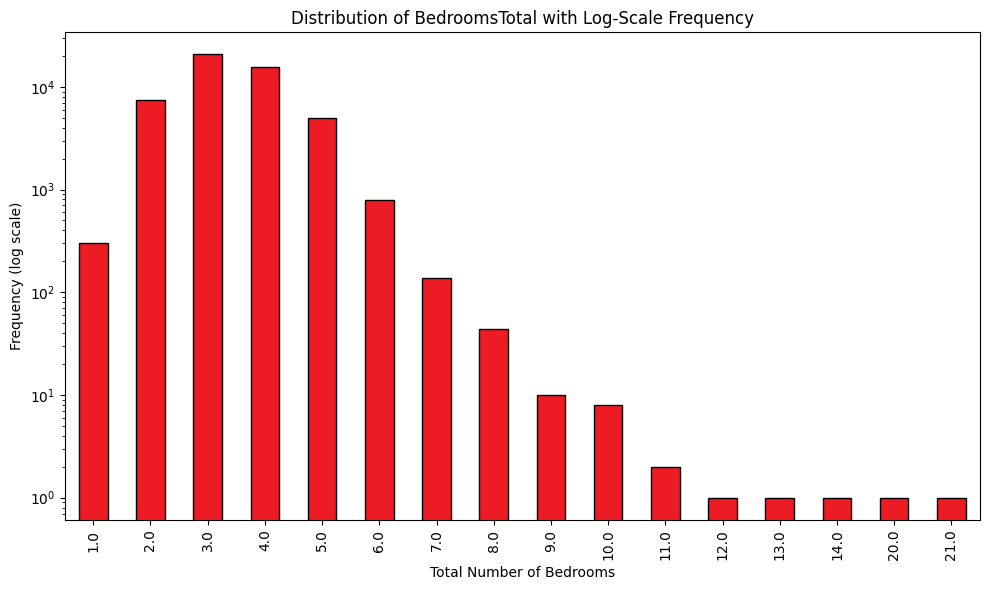

In [99]:
bedrooms_counts = df['BedroomsTotal'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bedrooms_counts.plot(kind='bar', color='#ED1C24', edgecolor='black', logy=True)
plt.title('Distribution of BedroomsTotal with Log-Scale Frequency')
plt.xlabel('Total Number of Bedrooms')
plt.ylabel('Frequency (log scale)')
plt.tight_layout()
plt.show()

#### FireplaceYN

In [100]:
df['FireplaceYN'] = df['FireplaceYN'].fillna('unknown')
fireplace_counts = df['FireplaceYN'].value_counts()
fireplace_counts

,count
FireplaceYN,
True,33992
False,12561
unknown,3472


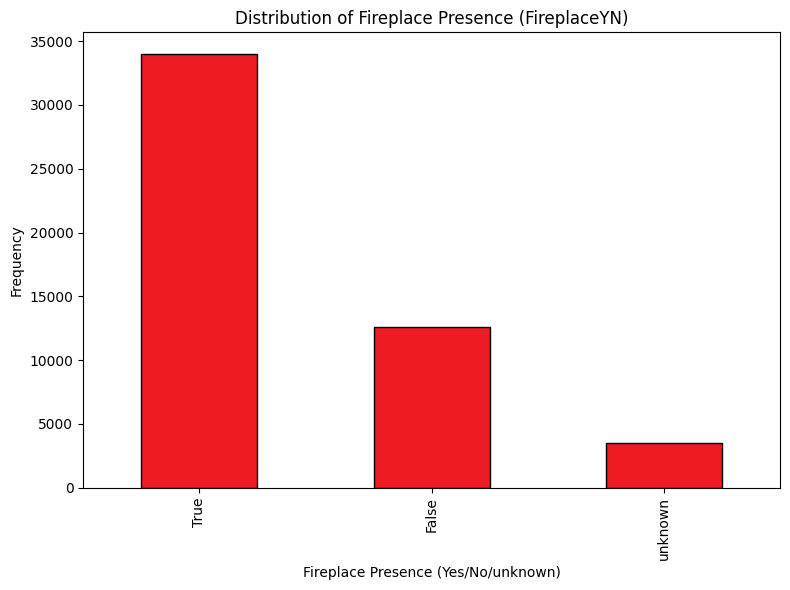

In [101]:
plt.figure(figsize=(8, 6))
fireplace_counts.plot(kind='bar', color='#ED1C24', edgecolor='black')
plt.title('Distribution of Fireplace Presence (FireplaceYN)')
plt.xlabel('Fireplace Presence (Yes/No/unknown)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

#### Stories

In [102]:
df['Stories'].describe()

,Stories
count,36245.000000
mean,1.355139
std,0.478562
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


#### Levels

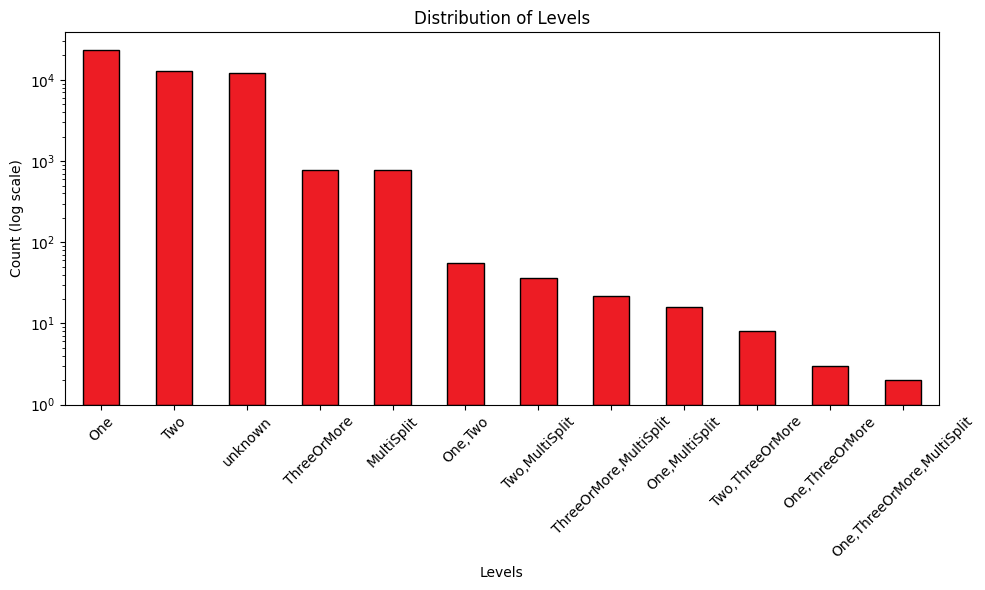

In [103]:
df['Levels'] = df['Levels'].fillna('unknown')

plt.figure(figsize=(10,6))
df['Levels'].value_counts().plot(kind='bar',  color='#ED1C24', edgecolor='black', log = True)
plt.title('Distribution of Levels')
plt.xlabel('Levels')
plt.ylabel('Count (log scale)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### NewConstructionYN

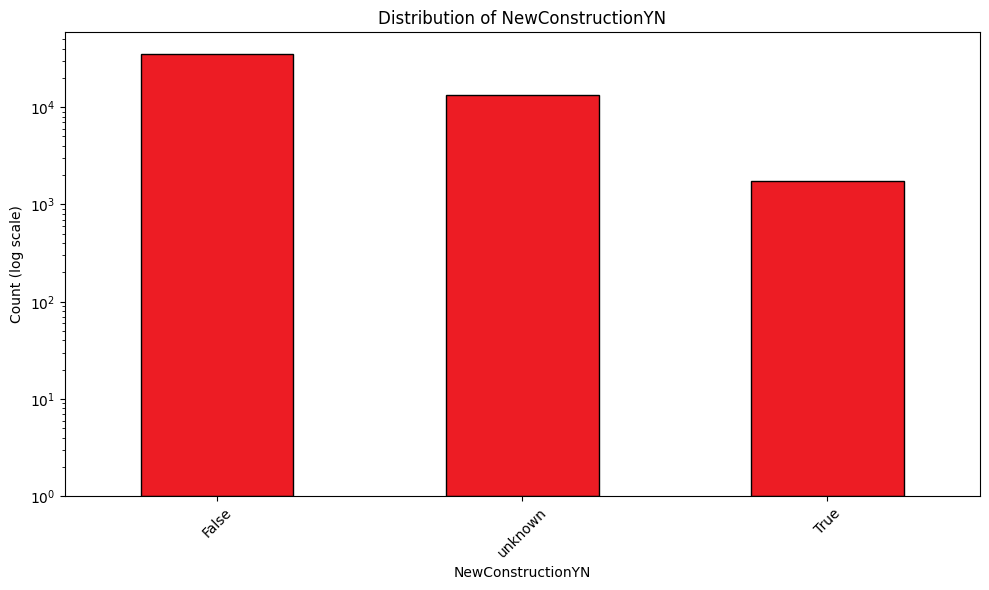

In [104]:
df['NewConstructionYN'] = df['NewConstructionYN'].fillna('unknown')

plt.figure(figsize=(10,6))
df['NewConstructionYN'].value_counts().plot(kind='bar',  color='#ED1C24', edgecolor='black', log = True)
plt.title('Distribution of NewConstructionYN')
plt.xlabel('NewConstructionYN')
plt.ylabel('Count (log scale)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### PostalCode

In [105]:
df['PostalCode'].value_counts()

,count
PostalCode,
92584,1704
92562,1534
92563,1486
92392,1408
92545,1216
...,...
94067,1
94605-3658,1
95129-3843,1


In [106]:
df.shape

(50025, 24)

In [107]:
df['PostalCode'] = df['PostalCode'].astype(str).str[:5]
df['PostalCode'] = pd.to_numeric(df['PostalCode'], errors='coerce')
df = df[(df['PostalCode'] >= 90001) & (df['PostalCode'] <= 96162)]
df['PostalCode'] = df['PostalCode'].astype('Int64')

<ipython-input-107-955e5124b37b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PostalCode'] = df['PostalCode'].astype('Int64')


In [108]:
df['PostalCode'].value_counts()

,count
PostalCode,
92584,1704
92562,1534
92563,1486
92392,1408
92545,1216
...,...
90247,1
92385,1
92455,1


In [109]:
df.shape

(50019, 24)

### Cross Plot

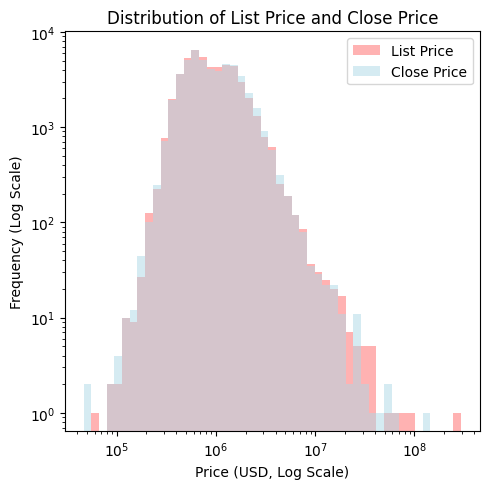

In [110]:
list_price = df['ListPrice'].dropna()
close_price = df['ClosePrice'].dropna()

min_val = min(list_price.min(), close_price.min())
max_val = max(list_price.max(), close_price.max())
bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)

plt.figure(figsize=(5, 5))
plt.hist(list_price, bins=bins, color='red', log=True, alpha=0.3, label='List Price')
plt.hist(close_price, bins=bins, color='lightblue', log=True, alpha=0.5, label='Close Price')

plt.xscale('log')
plt.yscale('log')
plt.title('Distribution of List Price and Close Price')
plt.xlabel('Price (USD, Log Scale)')
plt.ylabel('Frequency (Log Scale)')
plt.legend()

plt.tight_layout()
plt.show()


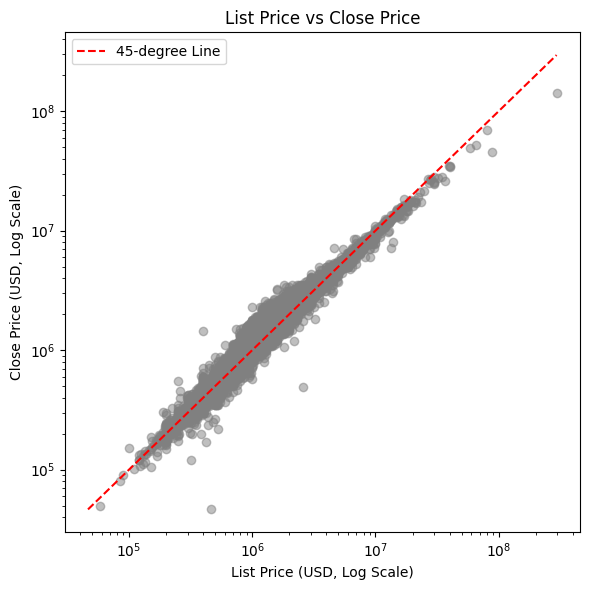

In [111]:
plt.figure(figsize=(6, 6))
plt.scatter(list_price, close_price, alpha=0.5, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('List Price (USD, Log Scale)')
plt.ylabel('Close Price (USD, Log Scale)')
plt.title('List Price vs Close Price')

max_val = max(max(list_price), max(close_price))
min_val = min(min(list_price), min(close_price))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='45-degree Line')
plt.legend()

plt.tight_layout()
plt.show()

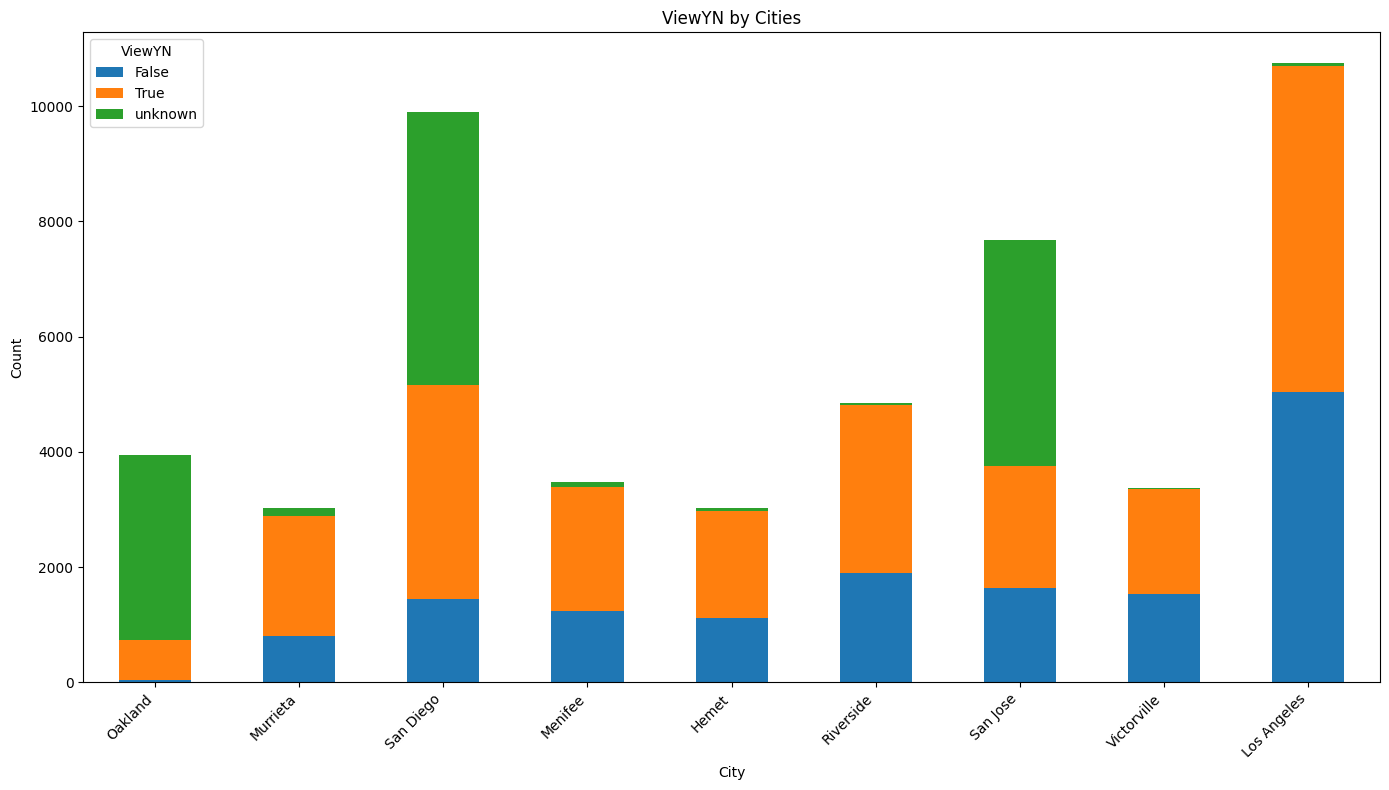

In [112]:
filtered_city_df = df[df['City'] != 'unknown']
top_20_cities = filtered_city_df['City'].value_counts().nlargest(20).index

top_20_city_df = filtered_city_df[filtered_city_df['City'].isin(top_20_cities)]

view_proportion = top_20_city_df.groupby(['City', 'ViewYN']).size().unstack(fill_value=0)
view_proportion['True_Proportion'] = view_proportion[True] / (view_proportion[True] + view_proportion[False])
sorted_cities = view_proportion.sort_values(by='True_Proportion', ascending=False).index

view_count = top_20_city_df.groupby(['City', 'ViewYN']).size().unstack(fill_value=0)
sorted_view_count = view_count.loc[sorted_cities]

sorted_view_count.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.xlabel('City')
plt.ylabel('Count')
plt.title('ViewYN by Cities')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

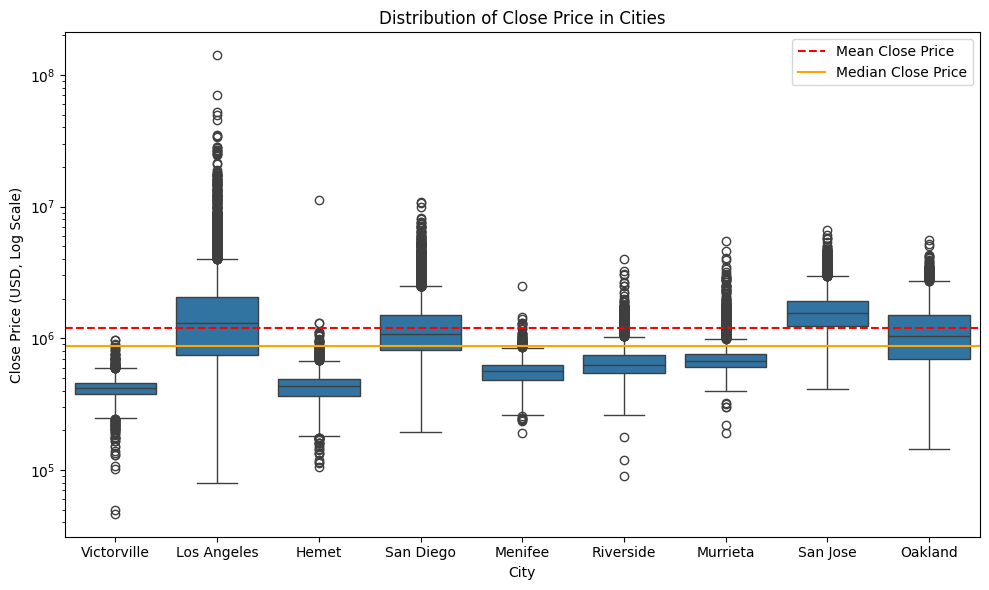

In [113]:
mean_close_price = df['ClosePrice'].mean()
median_close_price = df['ClosePrice'].median()

plt.figure(figsize=(10, 6))

sns.boxplot(data=df, x='City', y='ClosePrice')
plt.yscale('log')
plt.axhline(mean_close_price, color='red', linestyle='--', label='Mean Close Price')
plt.axhline(median_close_price, color='orange', linestyle='-', label='Median Close Price')
plt.title('Distribution of Close Price in Cities')
plt.xlabel('City')
plt.ylabel('Close Price (USD, Log Scale)')
plt.legend()

plt.tight_layout()
plt.show()

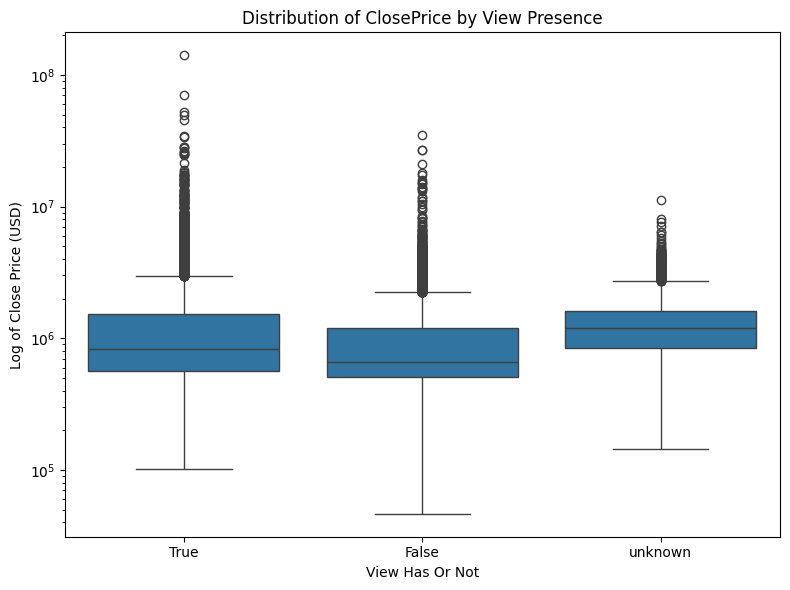

In [114]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='ViewYN', y='ClosePrice')
plt.yscale('log')
plt.title('Distribution of ClosePrice by View Presence')
plt.xlabel('View Has Or Not')
plt.ylabel('Log of Close Price (USD)')
plt.tight_layout()
plt.show()

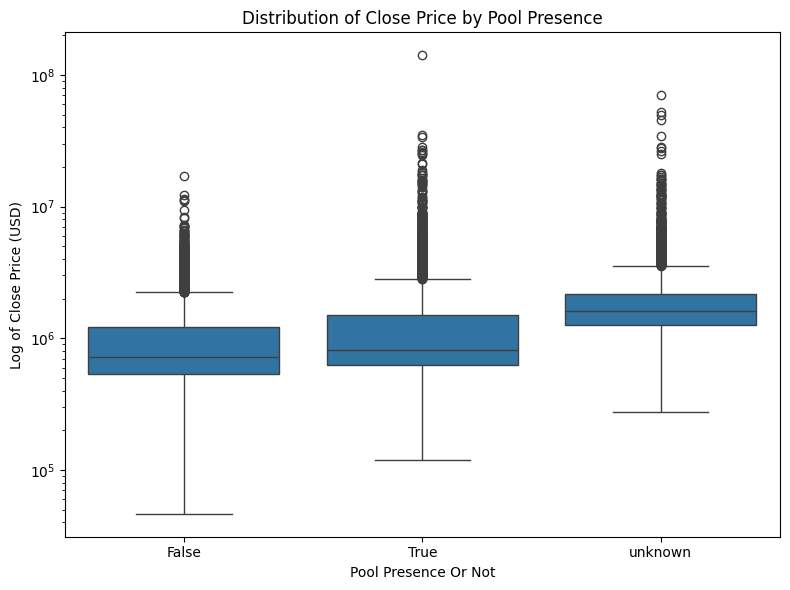

In [115]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='PoolPrivateYN', y='ClosePrice')
plt.yscale('log')
plt.title('Distribution of Close Price by Pool Presence')
plt.xlabel('Pool Presence Or Not')
plt.ylabel('Log of Close Price (USD)')
plt.tight_layout()
plt.show()

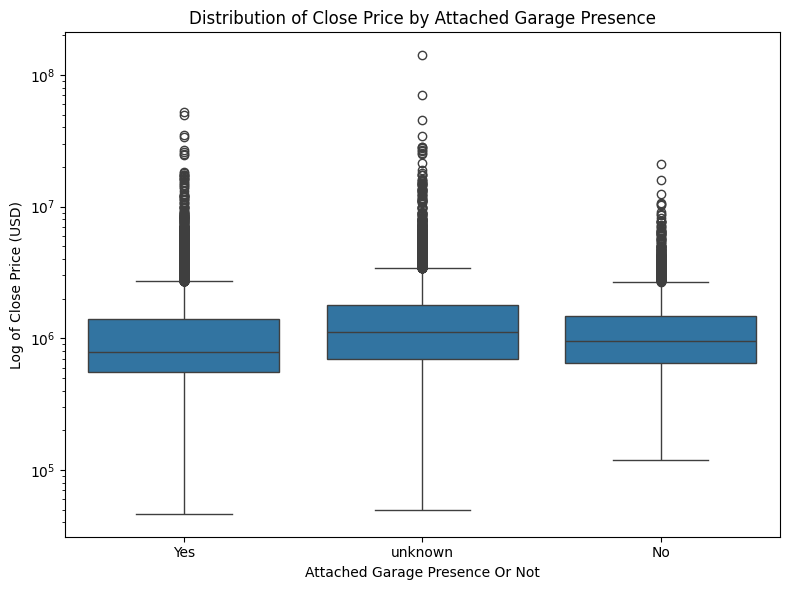

In [116]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='AttachedGarageYN', y='ClosePrice')
plt.yscale('log')
plt.title('Distribution of Close Price by Attached Garage Presence')
plt.xlabel('Attached Garage Presence Or Not')
plt.ylabel('Log of Close Price (USD)')
plt.tight_layout()
plt.show()

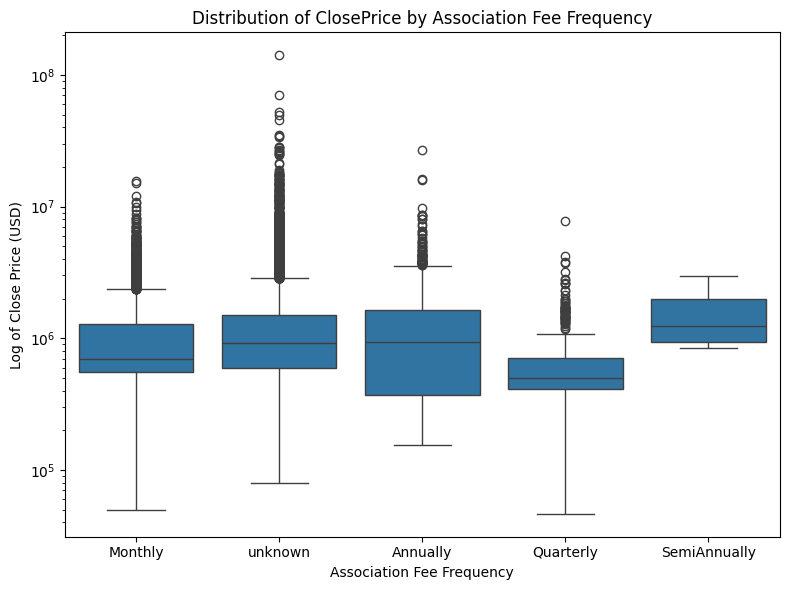

In [117]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='AssociationFeeFrequency', y='ClosePrice')
plt.yscale('log')
plt.title('Distribution of ClosePrice by Association Fee Frequency')
plt.xlabel('Association Fee Frequency')
plt.ylabel('Log of Close Price (USD)')
plt.tight_layout()
plt.show()

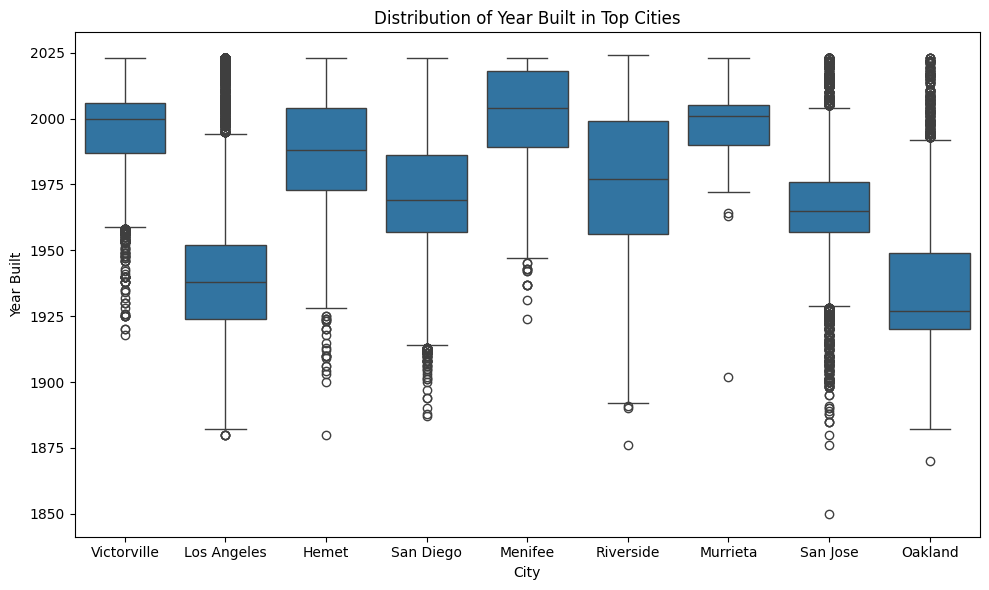

In [118]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='City', y='YearBuilt')
plt.title('Distribution of Year Built in Top Cities')
plt.ylabel('Year Built')
plt.xlabel('City')
plt.tight_layout()
plt.show()

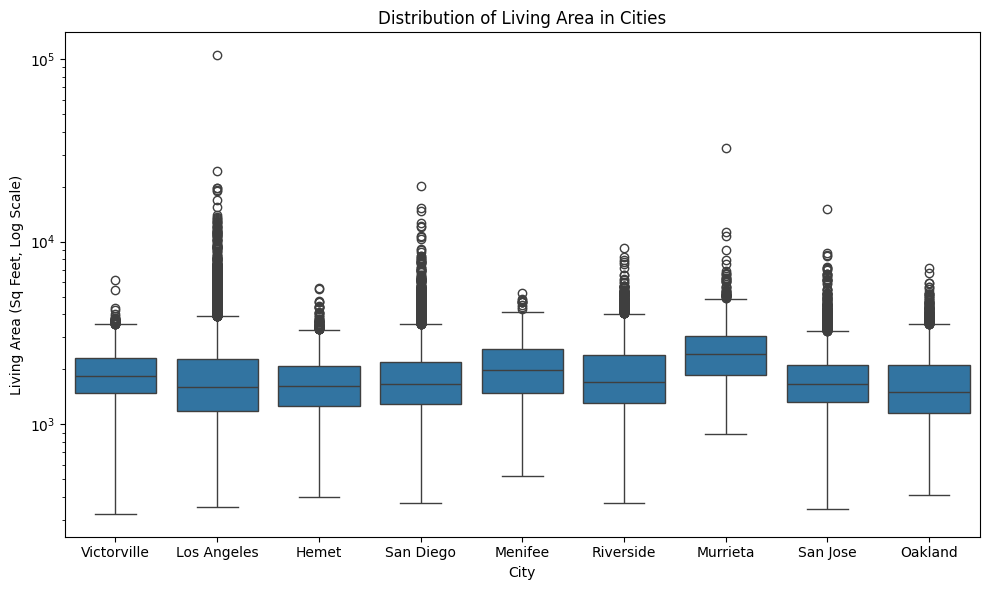

In [119]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='City', y='LivingArea')
plt.yscale('log')
plt.title('Distribution of Living Area in Cities')
plt.ylabel('Living Area (Sq Feet, Log Scale)')
plt.tight_layout()
plt.show()

In [120]:
df['City'].value_counts()

,count
City,
Los Angeles,10746
San Diego,9903
San Jose,7685
Riverside,4843
Oakland,3951
Menifee,3476
Victorville,3371
Hemet,3023
Murrieta,3021


In [121]:
df_2022 = df[df['CloseDate'].dt.year == 2022]
df_2023 = df[df['CloseDate'].dt.year == 2023]

df_2022_clean = df_2022['ClosePrice'].dropna()
df_2023_clean = df_2023['ClosePrice'].dropna()

# Calculate the mean and standard deviation for 2022 and 2023
mean_2022_clean = df_2022_clean.mean()
std_2022_clean = df_2022_clean.std()

mean_2023_clean = df_2023_clean.mean()
std_2023_clean = df_2023_clean.std()

# Create a dataframe to display the results
mean_std_comparison_clean = pd.DataFrame({
    'Year': ['2022', '2023'],
    'Mean ClosePrice': [mean_2022_clean, mean_2023_clean],
    'Std ClosePrice': [std_2022_clean, std_2023_clean]
})


In [122]:
mean_std_comparison_clean

,Year,Mean ClosePrice,Std ClosePrice
0,2022,1.201501e+06,1.539657e+06
1,2023,1.180283e+06,1.121252e+06


In [123]:
df.shape

(50019, 24)

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50019 entries, 0 to 50173
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Flooring                     50019 non-null  object        
 1   ViewYN                       50019 non-null  object        
 2   PoolPrivateYN                50019 non-null  object        
 3   CloseDate                    50019 non-null  datetime64[ns]
 4   ClosePrice                   50019 non-null  float64       
 5   Latitude                     50019 non-null  float64       
 6   Longitude                    50019 non-null  float64       
 7   LivingArea                   49963 non-null  float64       
 8   ListPrice                    50019 non-null  float64       
 9   DaysOnMarket                 50019 non-null  int64         
 10  AssociationFeeFrequency      50019 non-null  object        
 11  AttachedGarageYN             50019 non-null  o

In [125]:
columns_to_drop = ['CloseDate_Month']
df.drop(columns=columns_to_drop, inplace=True)

In [126]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 50019 entries, 0 to 50173
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Flooring                     50019 non-null  object        
 1   ViewYN                       50019 non-null  object        
 2   PoolPrivateYN                50019 non-null  object        
 3   CloseDate                    50019 non-null  datetime64[ns]
 4   ClosePrice                   50019 non-null  float64       
 5   Latitude                     50019 non-null  float64       
 6   Longitude                    50019 non-null  float64       
 7   LivingArea                   49963 non-null  float64       
 8   ListPrice                    50019 non-null  float64       
 9   DaysOnMarket                 50019 non-null  int64         
 10  AssociationFeeFrequency      50019 non-null  object        
 11  AttachedGarageYN             50019 non-null  o

In [127]:
missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_data_df = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage (%)': missing_percentage
})
print(missing_data_df)

                             Missing Values  Percentage (%)
Flooring                                  0        0.000000
ViewYN                                    0        0.000000
PoolPrivateYN                             0        0.000000
CloseDate                                 0        0.000000
ClosePrice                                0        0.000000
Latitude                                  0        0.000000
Longitude                                 0        0.000000
LivingArea                               56        0.111957
ListPrice                                 0        0.000000
DaysOnMarket                              0        0.000000
AssociationFeeFrequency                   0        0.000000
AttachedGarageYN                          0        0.000000
LotSizeAcres                           2119        4.236390
YearBuilt                                62        0.123953
BuyerAgencyCompensationType               0        0.000000
BathroomsTotalInteger                   

## Data Processing & Feature Eng

In [128]:
df_processed = df.copy()

### Data Processing   

In [129]:
flooring_split = df_processed['Flooring'].str.get_dummies(sep=',')
flooring_split.columns = ['Flooring_' + col.strip() for col in flooring_split.columns]
df_processed = pd.concat([df_processed, flooring_split], axis=1)
df_processed.drop(columns=['Flooring'], inplace=True)
df_processed

,ViewYN,PoolPrivateYN,CloseDate,ClosePrice,Latitude,Longitude,LivingArea,ListPrice,DaysOnMarket,AssociationFeeFrequency,...,Flooring_Brick,Flooring_Carpet,Flooring_Concrete,Flooring_Laminate,Flooring_SeeRemarks,Flooring_Stone,Flooring_Tile,Flooring_Vinyl,Flooring_Wood,Flooring_unknown
0,True,False,2022-01-03,400000.0,34.484085,-117.268684,1574.0,385000.0,11,Monthly,...,0,0,0,0,1,0,1,0,0,0
1,False,False,2022-03-11,2000000.0,34.020485,-118.427183,3226.0,2029000.0,89,unknown,...,0,0,0,0,0,0,1,0,1,0
2,True,False,2022-01-11,420000.0,33.737047,-116.944238,897.0,419900.0,14,unknown,...,0,1,0,1,0,0,1,0,0,0
3,True,False,2022-02-17,1050000.0,32.757772,-117.111742,1393.0,1075000.0,16,unknown,...,0,0,0,0,0,0,0,0,0,1
4,True,False,2022-01-20,2400000.0,34.102650,-118.359630,2645.0,2445000.0,70,unknown,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50169,False,False,2022-01-07,780000.0,33.638184,-117.120891,3772.0,780000.0,48,unknown,...,0,0,0,0,0,0,0,0,0,1
50170,False,True,2022-02-16,6100000.0,34.053484,-118.471204,5612.0,6399000.0,40,unknown,...,0,0,0,0,0,0,0,0,0,1
50171,False,False,2022-03-10,605000.0,33.991142,-118.288730,1928.0,695000.0,144,unknown,...,0,0,0,0,0,0,0,0,0,1
50172,True,False,2022-01-10,313000.0,33.735287,-116.906467,975.0,310000.0,56,unknown,...,0,0,0,0,0,0,0,0,0,1


In [130]:
levels_split = df_processed['Levels'].str.get_dummies(sep=',')
levels_split.columns = [f"Levels_{col}" for col in levels_split.columns]
df_processed = pd.concat([df_processed, levels_split], axis=1)
df_processed.drop(columns=['Levels'], inplace=True)
df_processed

,ViewYN,PoolPrivateYN,CloseDate,ClosePrice,Latitude,Longitude,LivingArea,ListPrice,DaysOnMarket,AssociationFeeFrequency,...,Flooring_Stone,Flooring_Tile,Flooring_Vinyl,Flooring_Wood,Flooring_unknown,Levels_MultiSplit,Levels_One,Levels_ThreeOrMore,Levels_Two,Levels_unknown
0,True,False,2022-01-03,400000.0,34.484085,-117.268684,1574.0,385000.0,11,Monthly,...,0,1,0,0,0,0,0,0,0,1
1,False,False,2022-03-11,2000000.0,34.020485,-118.427183,3226.0,2029000.0,89,unknown,...,0,1,0,1,0,0,0,0,0,1
2,True,False,2022-01-11,420000.0,33.737047,-116.944238,897.0,419900.0,14,unknown,...,0,1,0,0,0,0,1,0,0,0
3,True,False,2022-02-17,1050000.0,32.757772,-117.111742,1393.0,1075000.0,16,unknown,...,0,0,0,0,1,0,1,0,0,0
4,True,False,2022-01-20,2400000.0,34.102650,-118.359630,2645.0,2445000.0,70,unknown,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50169,False,False,2022-01-07,780000.0,33.638184,-117.120891,3772.0,780000.0,48,unknown,...,0,0,0,0,1,0,1,0,0,0
50170,False,True,2022-02-16,6100000.0,34.053484,-118.471204,5612.0,6399000.0,40,unknown,...,0,0,0,0,1,0,0,0,1,0
50171,False,False,2022-03-10,605000.0,33.991142,-118.288730,1928.0,695000.0,144,unknown,...,0,0,0,0,1,0,1,0,0,0
50172,True,False,2022-01-10,313000.0,33.735287,-116.906467,975.0,310000.0,56,unknown,...,0,0,0,0,1,0,1,0,0,0


### Data Eng

In [131]:
df_processed['CloseDate'] = pd.to_datetime(df_processed['CloseDate'], errors='coerce')
df_processed['CloseYear'] = df_processed['CloseDate'].dt.year
df_processed['CloseMonth'] = df_processed['CloseDate'].dt.month
df_processed.drop(columns=['CloseDate'], inplace=True)
df_processed

,ViewYN,PoolPrivateYN,ClosePrice,Latitude,Longitude,LivingArea,ListPrice,DaysOnMarket,AssociationFeeFrequency,AttachedGarageYN,...,Flooring_Vinyl,Flooring_Wood,Flooring_unknown,Levels_MultiSplit,Levels_One,Levels_ThreeOrMore,Levels_Two,Levels_unknown,CloseYear,CloseMonth
0,True,False,400000.0,34.484085,-117.268684,1574.0,385000.0,11,Monthly,Yes,...,0,0,0,0,0,0,0,1,2022,1
1,False,False,2000000.0,34.020485,-118.427183,3226.0,2029000.0,89,unknown,Yes,...,0,1,0,0,0,0,0,1,2022,3
2,True,False,420000.0,33.737047,-116.944238,897.0,419900.0,14,unknown,unknown,...,0,0,0,0,1,0,0,0,2022,1
3,True,False,1050000.0,32.757772,-117.111742,1393.0,1075000.0,16,unknown,No,...,0,0,1,0,1,0,0,0,2022,2
4,True,False,2400000.0,34.102650,-118.359630,2645.0,2445000.0,70,unknown,unknown,...,0,1,0,0,0,0,0,1,2022,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50169,False,False,780000.0,33.638184,-117.120891,3772.0,780000.0,48,unknown,No,...,0,0,1,0,1,0,0,0,2022,1
50170,False,True,6100000.0,34.053484,-118.471204,5612.0,6399000.0,40,unknown,Yes,...,0,0,1,0,0,0,1,0,2022,2
50171,False,False,605000.0,33.991142,-118.288730,1928.0,695000.0,144,unknown,unknown,...,0,0,1,0,1,0,0,0,2022,3
50172,True,False,313000.0,33.735287,-116.906467,975.0,310000.0,56,unknown,No,...,0,0,1,0,1,0,0,0,2022,1


In [132]:
print(df_processed.info())

<class 'pandas.core.frame.DataFrame'>
Index: 50019 entries, 0 to 50173
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ViewYN                       50019 non-null  object 
 1   PoolPrivateYN                50019 non-null  object 
 2   ClosePrice                   50019 non-null  float64
 3   Latitude                     50019 non-null  float64
 4   Longitude                    50019 non-null  float64
 5   LivingArea                   49963 non-null  float64
 6   ListPrice                    50019 non-null  float64
 7   DaysOnMarket                 50019 non-null  int64  
 8   AssociationFeeFrequency      50019 non-null  object 
 9   AttachedGarageYN             50019 non-null  object 
 10  LotSizeAcres                 47900 non-null  float64
 11  YearBuilt                    49957 non-null  float64
 12  BuyerAgencyCompensationType  50019 non-null  object 
 13  BathroomsTotalInteger

In [133]:
missing_data = df_processed.isnull().sum()
missing_percentage = (df_processed.isnull().sum() / len(df_processed)) * 100

missing_data_df = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage (%)': missing_percentage
})
print(missing_data_df)

                             Missing Values  Percentage (%)
ViewYN                                    0        0.000000
PoolPrivateYN                             0        0.000000
ClosePrice                                0        0.000000
Latitude                                  0        0.000000
Longitude                                 0        0.000000
LivingArea                               56        0.111957
ListPrice                                 0        0.000000
DaysOnMarket                              0        0.000000
AssociationFeeFrequency                   0        0.000000
AttachedGarageYN                          0        0.000000
LotSizeAcres                           2119        4.236390
YearBuilt                                62        0.123953
BuyerAgencyCompensationType               0        0.000000
BathroomsTotalInteger                    14        0.027989
City                                      0        0.000000
BedroomsTotal                           

### feature selection

In [134]:
threshold = 0.8

numerical_df = df_processed.select_dtypes(include=['number'])

correlation_matrix = numerical_df.corr()

high_corr_pairs = correlation_matrix.where((correlation_matrix > threshold) & (correlation_matrix < 1)).stack().reset_index()
high_corr_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']

high_corr_pairs


,Feature_1,Feature_2,Correlation
0,ClosePrice,ListPrice,0.943505
1,LivingArea,BathroomsTotalInteger,0.815483
2,ListPrice,ClosePrice,0.943505
3,BathroomsTotalInteger,LivingArea,0.815483
4,Stories,Levels_Two,0.996695
5,Levels_Two,Stories,0.996695


In [135]:
df_processed.drop(columns=['Stories', 'ListPrice'], inplace=True)

In [136]:
missing_data = df_processed.isnull().sum()
missing_percentage = (df_processed.isnull().sum() / len(df_processed)) * 100

missing_data_df = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage (%)': missing_percentage
})
print(missing_data_df)

                             Missing Values  Percentage (%)
ViewYN                                    0        0.000000
PoolPrivateYN                             0        0.000000
ClosePrice                                0        0.000000
Latitude                                  0        0.000000
Longitude                                 0        0.000000
LivingArea                               56        0.111957
DaysOnMarket                              0        0.000000
AssociationFeeFrequency                   0        0.000000
AttachedGarageYN                          0        0.000000
LotSizeAcres                           2119        4.236390
YearBuilt                                62        0.123953
BuyerAgencyCompensationType               0        0.000000
BathroomsTotalInteger                    14        0.027989
City                                      0        0.000000
BedroomsTotal                             0        0.000000
FireplaceYN                             

## ML pipeline

**- LivingArea has 56 missing values, the fraction is around 0.0.111975**

**- LotSizeAcres has 2118 missing values, the fraction is around 4.235068**

**- YearBuilt has 62 missing values, the fraction is around 0.123**

**- BathroomsTotalInteger has 14 missing values, the fraction is around 0.02**

for LivingArea, LotSizeAcres, YearBuilt, BathroomsTotalInteger, I apply multivariate imputation

In [137]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class ColumnNameRestorer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(X, columns=self.feature_names, index=range(len(X)))


def create_preprocessor_with_encoding(imputer, impute_cols, std_features, onehot_features, ordinal_features, ordinal_categories):
    impute_cols_wo_yearbuilt = [col for col in impute_cols if col != 'YearBuilt']

    num_features = [col for col in std_features if col not in impute_cols]

    yearbuilt_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal_encoder', OrdinalEncoder(categories=[ordinal_categories[0]],
                                           handle_unknown='use_encoded_value', unknown_value=-1)),

        ('rename', ColumnNameRestorer(['YearBuilt']))
    ])


    num_impute_pipeline = Pipeline([
        ('imputer', imputer),
        ('scaler', StandardScaler()),
        ('rename', ColumnNameRestorer(impute_cols_wo_yearbuilt))
    ])

    num_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rename', ColumnNameRestorer(num_features))
    ])

    def bool_to_str(X):
        return X.astype(str)

    onehot_pipeline = Pipeline([
        ('to_str', FunctionTransformer(bool_to_str)),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    ordinal_pipeline = Pipeline([
        ('ordinal_encoder', OrdinalEncoder(categories=ordinal_categories[1:],
                                           handle_unknown='use_encoded_value', unknown_value=-1))
    ])

    ordinal_full_pipeline = Pipeline([
        ('to_str', FunctionTransformer(bool_to_str)),
        ('ordinal', ordinal_pipeline),
        ('rename', ColumnNameRestorer(ordinal_features[1:]))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num_impute', num_impute_pipeline, impute_cols_wo_yearbuilt),
            ('num', num_pipeline, num_features),
            ('yearbuilt', yearbuilt_pipeline, ['YearBuilt']),
            ('onehot', onehot_pipeline, onehot_features),
            ('ordinal', ordinal_full_pipeline, ordinal_features[1:])
        ],
        remainder='passthrough'
    )

    return preprocessor



def MLpipe_MultipleImputations(X, y, df_processed, impute_cols, ML_algo, param_grid):
    test_scores_all = []
    best_models_all = []

    X_other, X_test, y_other, y_test = train_test_split(
        X, y, test_size=0.2, stratify=df_processed['City'], random_state=42)
    print(f"Initial split -> X_other size: {X_other.shape}, X_test size: {X_test.shape}")

    imputers = [
        IterativeImputer(estimator=RandomForestRegressor(n_estimators=1, random_state=42 * i), random_state=42 * i)
        for i in range(1, 4)
    ]

    std_features = ['Latitude', 'Longitude', 'LivingArea', 'DaysOnMarket',
                    'LotSizeAcres', 'BathroomsTotalInteger', 'BedroomsTotal']
    onehot_features = ['ViewYN', 'PoolPrivateYN', 'AttachedGarageYN', 'BuyerAgencyCompensationType',
                       'City', 'FireplaceYN', 'NewConstructionYN', 'PostalCode']
    ordinal_features = ['YearBuilt', 'CloseMonth', 'AssociationFeeFrequency', 'CloseYear']
    ordinal_categories = [
        list(range(1800, 2100)),  # YearBuilt
        list(range(1, 13)),      # CloseMonth
        ['Monthly', 'Quarterly', 'SemiAnnually', 'Annually', 'unknown'],  # AssociationFeeFrequency
        list(range(2021, 2024))  # CloseYear
    ]

    for imputer_id, imputer in enumerate(imputers, start=1):
        print(f"\nRunning with Imputation Strategy {imputer_id}...")

        preprocessor = create_preprocessor_with_encoding(
            imputer=imputer,
            impute_cols=impute_cols,
            std_features=std_features,
            onehot_features=onehot_features,
            ordinal_features=ordinal_features,
            ordinal_categories=ordinal_categories
        )

        test_scores = []
        best_models = []

        # StratifiedKFold
        kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        for fold, (train_index, val_index) in enumerate(kf.split(X_other, df_processed.loc[X_other.index, 'City'])):
            print(f"Starting Fold {fold + 1} for Imputation Strategy {imputer_id}")

            X_train_fold = X_other.iloc[train_index]
            y_train_fold = y_other.iloc[train_index]
            X_val_fold = X_other.iloc[val_index]
            y_val_fold = y_other.iloc[val_index]

            pipe = Pipeline([
                ('preprocessor', preprocessor),
                ('model', ML_algo)
            ])

            grid_search = GridSearchCV(
                estimator=pipe,
                param_grid=param_grid,
                cv=3,
                scoring='neg_root_mean_squared_error',
                n_jobs=-1,
                verbose=True,
                error_score='raise'
            )

            grid_search.fit(X_train_fold, y_train_fold)

            best_model = grid_search.best_estimator_
            best_rmse = -grid_search.best_score_
            print(f"Best parameters for fold {fold + 1}: {grid_search.best_params_}")
            print(f"Best RMSE on validation set for fold {fold + 1}: {best_rmse}")

            y_pred_val = best_model.predict(X_val_fold)
            val_rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val))
            print(f"Validation RMSE for fold {fold + 1}: {val_rmse}")

            best_models.append(best_model)
            test_scores.append(val_rmse)

        mean_rmse = np.mean(test_scores)
        std_rmse = np.std(test_scores)
        print(f"\nImputation Strategy {imputer_id} -> Average Validation RMSE: {mean_rmse:.4f}")
        print(f"Imputation Strategy {imputer_id} -> Standard Deviation of Validation RMSE: {std_rmse:.4f}")

        test_scores_all.append(test_scores)
        best_models_all.append(best_models)

    print("\nFinal Evaluation on Test Set...")
    test_rmse_all = []
    for imputer_id, models in enumerate(best_models_all, start=1):
        print(f"Evaluating Test Set with Imputation Strategy {imputer_id}")
        avg_scores_per_model = [np.mean(scores) for scores in test_scores_all[imputer_id - 1]]
        best_model_idx = np.argmin(avg_scores_per_model)
        final_best_model = models[best_model_idx]
        y_pred_test = final_best_model.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        test_rmse_all.append(test_rmse)
        print(f"Test RMSE for Imputation Strategy {imputer_id}: {test_rmse:.4f}")

    avg_test_rmse = np.mean(test_rmse_all)
    print(f"\nAverage Test RMSE Across All Imputation Strategies: {avg_test_rmse:.4f}")

    return test_scores_all, best_models_all, test_rmse_all


In [138]:
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
models_and_params = {
    "L1 Regularization (Lasso)": (
        Lasso(),
        {'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
    ),
    "L2 Regularization (Ridge)": (
        Ridge(),
        {'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
    ),
    "K-Nearest Neighbors (KNN)": (
        KNeighborsRegressor(),
        {
            'model__n_neighbors': [1, 5, 10, 100],
            'model__weights': ['uniform', 'distance']
        }
    ),
    "XGBoost": (
        XGBRegressor(random_state=42, verbosity=0),
        {
            'model__learning_rate': [0.03],
            'model__n_estimators': [100],
            'model__seed': [0],
            'model__reg_alpha': [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
            'model__reg_lambda': [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
            'model__missing': [np.nan],
            'model__max_depth': [1, 3, 10, 30, 100],
            'model__colsample_bytree': [0.9],
            'model__subsample': [0.66]
        }
    ),
    "Random Forest (RF)": (
        RandomForestRegressor(random_state=42),
        {
            'model__n_estimators': [100],
            'model__max_depth': [1, 3, 10, 20],
            'model__max_features': [0.25, 0.5, 0.75, 1.0]
        }
    )
}

#### subdata

In [139]:
subset_fraction = 0.05
df_subset = df_processed.sample(frac=subset_fraction, random_state=42)
X = df_subset.drop(columns=['ClosePrice'])
y = df_subset['ClosePrice']

In [140]:
impute_cols = ['LivingArea', 'LotSizeAcres', 'BathroomsTotalInteger', 'YearBuilt']

results = {}

for name, (model, param_grid) in models_and_params.items():
    print(f"Training {name}...")

    test_scores_all, best_models_all, test_rmse_all = MLpipe_MultipleImputations(
        X=X,
        y=y,
        df_processed=df_subset,
        impute_cols=impute_cols,
        ML_algo=model,
        param_grid=param_grid
    )
    results[name] = {
        "Validation Scores (per imputation strategy)": test_scores_all,
        "Best Models (per imputation strategy)": best_models_all,
        "Test Scores (per imputation strategy)": test_rmse_all
    }

for name, result in results.items():
    print(f"\n{name}:")
    # result["Test Scores (per imputation strategy)"]
    for i, test_rmse in enumerate(result["Test Scores (per imputation strategy)"], start=1):
        print(f"Imputation Strategy {i}: Test RMSE = {test_rmse:.4f}")


Training L1 Regularization (Lasso)...
Initial split -> X_other size: (2000, 35), X_test size: (501, 35)

Running with Imputation Strategy 1...
Starting Fold 1 for Imputation Strategy 1
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59141030811089.6, tolerance: 128146261683.43121
  model = cd_fast.sparse_enet_coordinate_descent(


Best parameters for fold 1: {'model__alpha': 100.0}
Best RMSE on validation set for fold 1: 477137.24972829927
Validation RMSE for fold 1: 360222.4964120148
Starting Fold 2 for Imputation Strategy 1
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34405724382792.305, tolerance: 116054308926.25508
  model = cd_fast.sparse_enet_coordinate_descent(


Best parameters for fold 2: {'model__alpha': 100.0}
Best RMSE on validation set for fold 2: 432214.55238565424
Validation RMSE for fold 2: 482748.0187615401
Starting Fold 3 for Imputation Strategy 1
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87295463359000.58, tolerance: 110995867627.96132
  model = cd_fast.sparse_enet_coordinate_descent(


Best parameters for fold 3: {'model__alpha': 0.01}
Best RMSE on validation set for fold 3: 434310.41896554217
Validation RMSE for fold 3: 447704.8380590069

Imputation Strategy 1 -> Average Validation RMSE: 430225.1177
Imputation Strategy 1 -> Standard Deviation of Validation RMSE: 51525.2778

Running with Imputation Strategy 2...
Starting Fold 1 for Imputation Strategy 2
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59098884614905.92, tolerance: 128146261683.43121
  model = cd_fast.sparse_enet_coordinate_descent(


Best parameters for fold 1: {'model__alpha': 100.0}
Best RMSE on validation set for fold 1: 476752.8061658179
Validation RMSE for fold 1: 360145.9803138129
Starting Fold 2 for Imputation Strategy 2
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34457024164981.156, tolerance: 116054308926.25508
  model = cd_fast.sparse_enet_coordinate_descent(


Best parameters for fold 2: {'model__alpha': 100.0}
Best RMSE on validation set for fold 2: 432467.12191716186
Validation RMSE for fold 2: 482787.6937047366
Starting Fold 3 for Imputation Strategy 2
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87330450972242.83, tolerance: 110995867627.96132
  model = cd_fast.sparse_enet_coordinate_descent(


Best parameters for fold 3: {'model__alpha': 0.01}
Best RMSE on validation set for fold 3: 434331.6653562944
Validation RMSE for fold 3: 447602.75104034075

Imputation Strategy 2 -> Average Validation RMSE: 430178.8084
Imputation Strategy 2 -> Standard Deviation of Validation RMSE: 51561.8903

Running with Imputation Strategy 3...
Starting Fold 1 for Imputation Strategy 3
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59137473956308.31, tolerance: 128146261683.43121
  model = cd_fast.sparse_enet_coordinate_descent(


Best parameters for fold 1: {'model__alpha': 100.0}
Best RMSE on validation set for fold 1: 476902.310304052
Validation RMSE for fold 1: 360176.0875151362
Starting Fold 2 for Imputation Strategy 3
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34467536673846.64, tolerance: 116054308926.25508
  model = cd_fast.sparse_enet_coordinate_descent(


Best parameters for fold 2: {'model__alpha': 100.0}
Best RMSE on validation set for fold 2: 430755.54726964916
Validation RMSE for fold 2: 482797.6365808789
Starting Fold 3 for Imputation Strategy 3
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87309453505236.38, tolerance: 110995867627.96132
  model = cd_fast.sparse_enet_coordinate_descent(


Best parameters for fold 3: {'model__alpha': 0.01}
Best RMSE on validation set for fold 3: 434136.63208280917
Validation RMSE for fold 3: 448459.1117373352

Imputation Strategy 3 -> Average Validation RMSE: 430477.6119
Imputation Strategy 3 -> Standard Deviation of Validation RMSE: 51649.5358

Final Evaluation on Test Set...
Evaluating Test Set with Imputation Strategy 1
Test RMSE for Imputation Strategy 1: 378324.7354
Evaluating Test Set with Imputation Strategy 2
Test RMSE for Imputation Strategy 2: 378742.3667
Evaluating Test Set with Imputation Strategy 3
Test RMSE for Imputation Strategy 3: 378720.2798

Average Test RMSE Across All Imputation Strategies: 378595.7940
Training L2 Regularization (Ridge)...
Initial split -> X_other size: (2000, 35), X_test size: (501, 35)

Running with Imputation Strategy 1...
Starting Fold 1 for Imputation Strategy 1
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters for fold 1: {'model__alpha': 1.0}
Best RMSE on validation s

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for fold 1: {'model__colsample_bytree': 0.9, 'model__learning_rate': 0.03, 'model__max_depth': 100, 'model__missing': nan, 'model__n_estimators': 100, 'model__reg_alpha': 0.1, 'model__reg_lambda': 0.1, 'model__seed': 0, 'model__subsample': 0.66}
Best RMSE on validation set for fold 1: 448426.4676830459
Validation RMSE for fold 1: 344546.9909002288
Starting Fold 2 for Imputation Strategy 1
Fitting 3 folds for each of 180 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for fold 2: {'model__colsample_bytree': 0.9, 'model__learning_rate': 0.03, 'model__max_depth': 30, 'model__missing': nan, 'model__n_estimators': 100, 'model__reg_alpha': 100.0, 'model__reg_lambda': 0.0, 'model__seed': 0, 'model__subsample': 0.66}
Best RMSE on validation set for fold 2: 403280.2602505419
Validation RMSE for fold 2: 396642.93914959393
Starting Fold 3 for Imputation Strategy 1
Fitting 3 folds for each of 180 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for fold 3: {'model__colsample_bytree': 0.9, 'model__learning_rate': 0.03, 'model__max_depth': 10, 'model__missing': nan, 'model__n_estimators': 100, 'model__reg_alpha': 10.0, 'model__reg_lambda': 0.0, 'model__seed': 0, 'model__subsample': 0.66}
Best RMSE on validation set for fold 3: 413766.61763137387
Validation RMSE for fold 3: 450764.02516940166

Imputation Strategy 1 -> Average Validation RMSE: 397317.9851
Imputation Strategy 1 -> Standard Deviation of Validation RMSE: 43365.5497

Running with Imputation Strategy 2...
Starting Fold 1 for Imputation Strategy 2
Fitting 3 folds for each of 180 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for fold 1: {'model__colsample_bytree': 0.9, 'model__learning_rate': 0.03, 'model__max_depth': 10, 'model__missing': nan, 'model__n_estimators': 100, 'model__reg_alpha': 100.0, 'model__reg_lambda': 0.1, 'model__seed': 0, 'model__subsample': 0.66}
Best RMSE on validation set for fold 1: 452495.70039270096
Validation RMSE for fold 1: 337741.2002514537
Starting Fold 2 for Imputation Strategy 2
Fitting 3 folds for each of 180 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for fold 2: {'model__colsample_bytree': 0.9, 'model__learning_rate': 0.03, 'model__max_depth': 30, 'model__missing': nan, 'model__n_estimators': 100, 'model__reg_alpha': 10.0, 'model__reg_lambda': 0.01, 'model__seed': 0, 'model__subsample': 0.66}
Best RMSE on validation set for fold 2: 405171.2273018667
Validation RMSE for fold 2: 394028.72518463986
Starting Fold 3 for Imputation Strategy 2
Fitting 3 folds for each of 180 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for fold 3: {'model__colsample_bytree': 0.9, 'model__learning_rate': 0.03, 'model__max_depth': 30, 'model__missing': nan, 'model__n_estimators': 100, 'model__reg_alpha': 0.01, 'model__reg_lambda': 0.0, 'model__seed': 0, 'model__subsample': 0.66}
Best RMSE on validation set for fold 3: 412537.36344484816
Validation RMSE for fold 3: 450392.78056382603

Imputation Strategy 2 -> Average Validation RMSE: 394054.2353
Imputation Strategy 2 -> Standard Deviation of Validation RMSE: 45989.8186

Running with Imputation Strategy 3...
Starting Fold 1 for Imputation Strategy 3
Fitting 3 folds for each of 180 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for fold 1: {'model__colsample_bytree': 0.9, 'model__learning_rate': 0.03, 'model__max_depth': 10, 'model__missing': nan, 'model__n_estimators': 100, 'model__reg_alpha': 100.0, 'model__reg_lambda': 0.1, 'model__seed': 0, 'model__subsample': 0.66}
Best RMSE on validation set for fold 1: 446115.04340610077
Validation RMSE for fold 1: 340858.1225384034
Starting Fold 2 for Imputation Strategy 3
Fitting 3 folds for each of 180 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for fold 2: {'model__colsample_bytree': 0.9, 'model__learning_rate': 0.03, 'model__max_depth': 100, 'model__missing': nan, 'model__n_estimators': 100, 'model__reg_alpha': 10.0, 'model__reg_lambda': 0.01, 'model__seed': 0, 'model__subsample': 0.66}
Best RMSE on validation set for fold 2: 403217.0382928305
Validation RMSE for fold 2: 401477.5321924747
Starting Fold 3 for Imputation Strategy 3
Fitting 3 folds for each of 180 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for fold 3: {'model__colsample_bytree': 0.9, 'model__learning_rate': 0.03, 'model__max_depth': 10, 'model__missing': nan, 'model__n_estimators': 100, 'model__reg_alpha': 10.0, 'model__reg_lambda': 0.1, 'model__seed': 0, 'model__subsample': 0.66}
Best RMSE on validation set for fold 3: 413320.6909451553
Validation RMSE for fold 3: 459103.9072693772

Imputation Strategy 3 -> Average Validation RMSE: 400479.8540
Imputation Strategy 3 -> Standard Deviation of Validation RMSE: 48278.7940

Final Evaluation on Test Set...
Evaluating Test Set with Imputation Strategy 1
Test RMSE for Imputation Strategy 1: 342233.7962
Evaluating Test Set with Imputation Strategy 2
Test RMSE for Imputation Strategy 2: 341989.1151
Evaluating Test Set with Imputation Strategy 3
Test RMSE for Imputation Strategy 3: 341578.7272

Average Test RMSE Across All Imputation Strategies: 341933.8795
Training Random Forest (RF)...
Initial split -> X_other size: (2000, 35), X_test size: (501, 35)

Running with

## Baseline

In [141]:
def compute_baseline_mean(y_train):
    baseline_mean = y_train.mean()
    print(f"Baseline (y_train mean): {baseline_mean:.4f}")
    return baseline_mean

X_other, X_test, y_other, y_test = train_test_split(
    X, y, test_size=0.2, stratify=df_subset['City'], random_state=42)

baseline_mean = compute_baseline_mean(y_other)


Baseline (y_train mean): 1159405.9920


In [142]:
X_other.shape, X_test.shape

((2000, 35), (501, 35))

## Result

In [143]:
summary = {}
for algo, data in results.items():

    test_scores = data["Test Scores (per imputation strategy)"]
    mean_rmse = np.mean(test_scores)
    std_rmse = np.std(test_scores)
    summary[algo] = {"Mean RMSE": mean_rmse, "Std RMSE": std_rmse}

lowest_mean_algo = min(summary, key=lambda x: summary[x]["Mean RMSE"])
summary_sorted_mean = sorted(summary.items(), key=lambda x: x[1]["Mean RMSE"])

lowest_sd_algo = min(summary, key=lambda x: summary[x]["Std RMSE"])
summary_sorted_sd = sorted(summary.items(), key=lambda x: x[1]["Std RMSE"])

lowest_mean_algo_result = summary[lowest_mean_algo]
lowest_sd_algo_result = summary[lowest_sd_algo]

print("Sorted by Mean RMSE:", summary_sorted_mean)
print("Sorted by Std RMSE:", summary_sorted_sd)
print("Lowest Mean RMSE Algo and Result:", lowest_mean_algo, lowest_mean_algo_result)
print("Lowest Std RMSE Algo and Result:", lowest_sd_algo, lowest_sd_algo_result)


Sorted by Mean RMSE: [('XGBoost', {'Mean RMSE': 341933.87947967945, 'Std RMSE': 270.2678739654926}), ('Random Forest (RF)', {'Mean RMSE': 361649.07764921896, 'Std RMSE': 6654.347030622721}), ('L2 Regularization (Ridge)', {'Mean RMSE': 375379.65942631656, 'Std RMSE': 187.57897393160462}), ('L1 Regularization (Lasso)', {'Mean RMSE': 378595.79398003203, 'Std RMSE': 191.8793532007282}), ('K-Nearest Neighbors (KNN)', {'Mean RMSE': 487870.5094912206, 'Std RMSE': 41.52168176448973})]
Sorted by Std RMSE: [('K-Nearest Neighbors (KNN)', {'Mean RMSE': 487870.5094912206, 'Std RMSE': 41.52168176448973}), ('L2 Regularization (Ridge)', {'Mean RMSE': 375379.65942631656, 'Std RMSE': 187.57897393160462}), ('L1 Regularization (Lasso)', {'Mean RMSE': 378595.79398003203, 'Std RMSE': 191.8793532007282}), ('XGBoost', {'Mean RMSE': 341933.87947967945, 'Std RMSE': 270.2678739654926}), ('Random Forest (RF)', {'Mean RMSE': 361649.07764921896, 'Std RMSE': 6654.347030622721})]
Lowest Mean RMSE Algo and Result: XGB

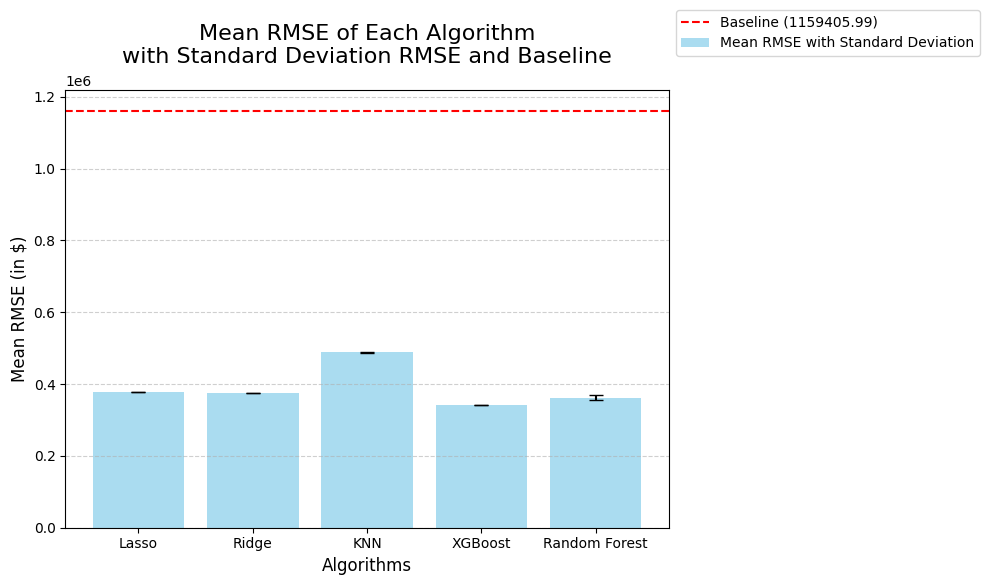

In [144]:
import matplotlib.pyplot as plt
import numpy as np

# Extract algorithm names and RMSE metrics
algorithms = list(summary.keys())
mean_rmse = [summary[algo]["Mean RMSE"] for algo in algorithms]
std_rmse = [summary[algo]["Std RMSE"] for algo in algorithms]

# Mapping full names to simplified names for better visualization
name_map = {
    "L1 Regularization (Lasso)": "Lasso",
    "L2 Regularization (Ridge)": "Ridge",
    "K-Nearest Neighbors (KNN)": "KNN",
    "XGBoost": "XGBoost",
    "Random Forest (RF)": "Random Forest"
}
algorithm_names = [name_map.get(algo, algo) for algo in algorithms]
plt.figure(figsize=(10, 6))

bars = plt.bar(algorithm_names, mean_rmse, yerr=std_rmse, alpha=0.7,
               color='skyblue', capsize=5, label='Mean RMSE with Standard Deviation')

# Adding a baseline line
plt.axhline(y=baseline_mean, color='red', linestyle='--', linewidth=1.5, label=f'Baseline ({baseline_mean:.2f})')


plt.xlabel("Algorithms", fontsize=12)
plt.ylabel("Mean RMSE (in $)", fontsize=12)
plt.title("Mean RMSE of Each Algorithm\nwith Standard Deviation RMSE and Baseline", fontsize=16, pad=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1.2), ncol=1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


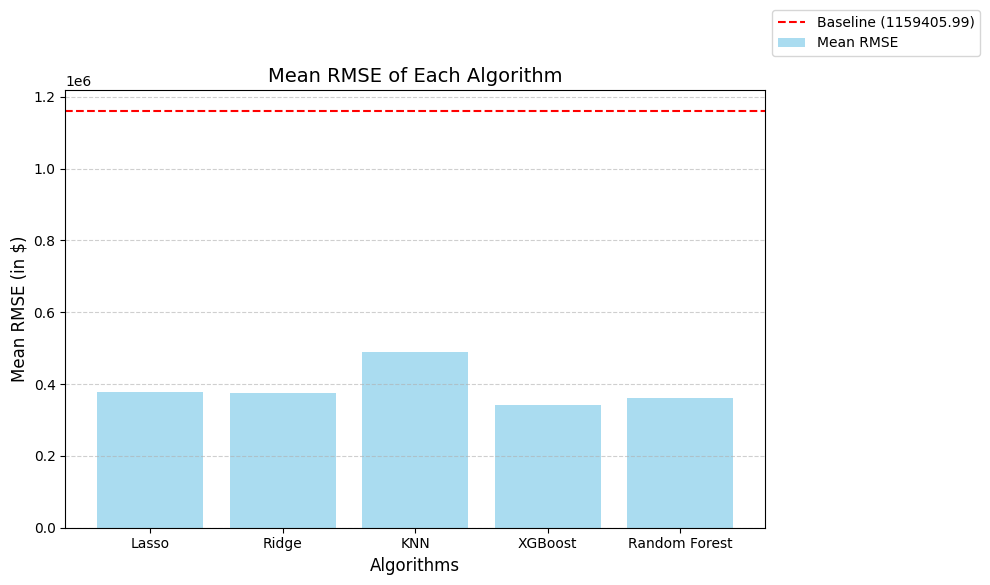

In [145]:
import matplotlib.pyplot as plt
import numpy as np

algorithms = list(summary.keys())
mean_rmse = [summary[algo]["Mean RMSE"] for algo in algorithms]

name_map = {
    "L1 Regularization (Lasso)": "Lasso",
    "L2 Regularization (Ridge)": "Ridge",
    "K-Nearest Neighbors (KNN)": "KNN",
    "XGBoost": "XGBoost",
    "Random Forest (RF)": "Random Forest"
}
algorithm_names = [name_map.get(algo, algo) for algo in algorithms]
plt.figure(figsize=(10, 6))

bars = plt.bar(algorithm_names, mean_rmse, alpha=0.7,
               color='skyblue', capsize=5, label='Mean RMSE')

plt.axhline(y=baseline_mean, color='red', linestyle='--', linewidth=1.5, label=f'Baseline ({baseline_mean:.2f})')

plt.xlabel("Algorithms", fontsize=12)
plt.ylabel("Mean RMSE (in $)", fontsize=12)
plt.title("Mean RMSE of Each Algorithm", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1.2), ncol=1)
plt.grid(axis='y', linestyle='--', alpha=0.6)  # Adding grid lines for better readability
plt.tight_layout()

plt.show()


In [146]:
result_summary = {}

for algo, data in results.items():
    test_scores = data["Test Scores (per imputation strategy)"]
    result_summary[algo] = {
        "Test Scores": test_scores,
    }

print(result_summary)


{'L1 Regularization (Lasso)': {'Test Scores': [378324.7353860558, 378742.36674797913, 378720.27980606107]}, 'L2 Regularization (Ridge)': {'Test Scores': [375114.9928729077, 375527.56571884576, 375496.4196871961]}, 'K-Nearest Neighbors (KNN)': {'Test Scores': [487885.1817672798, 487912.4137666869, 487813.9329396949]}, 'XGBoost': {'Test Scores': [342233.7961904294, 341989.11508256453, 341578.7271660444]}, 'Random Forest (RF)': {'Test Scores': [362222.6566009253, 353227.5627941317, 369497.01355259994]}}


In [147]:
result_summary_with_std = {}

for algo, data in result_summary.items():
    test_scores = data["Test Scores"]
    scores_diff = [score - baseline_mean for score in test_scores]
    std_diff = np.std(scores_diff)

    result_summary_with_std[algo] = {
        "Test Scores": test_scores,
        "Std with Baseline": std_diff
    }

print(result_summary_with_std)


{'L1 Regularization (Lasso)': {'Test Scores': [378324.7353860558, 378742.36674797913, 378720.27980606107], 'Std with Baseline': 191.87935320071338}, 'L2 Regularization (Ridge)': {'Test Scores': [375114.9928729077, 375527.56571884576, 375496.4196871961], 'Std with Baseline': 187.578973931574}, 'K-Nearest Neighbors (KNN)': {'Test Scores': [487885.1817672798, 487912.4137666869, 487813.9329396949], 'Std with Baseline': 41.52168176445643}, 'XGBoost': {'Test Scores': [342233.7961904294, 341989.11508256453, 341578.7271660444], 'Std with Baseline': 270.2678739655141}, 'Random Forest (RF)': {'Test Scores': [362222.6566009253, 353227.5627941317, 369497.01355259994], 'Std with Baseline': 6654.347030622722}}


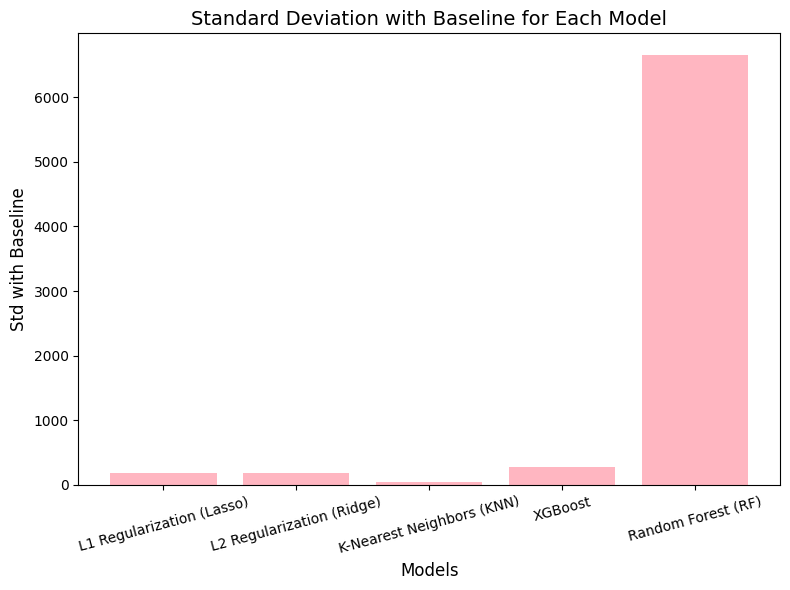

In [148]:
models = list(result_summary_with_std.keys())
std_with_baseline = [data["Std with Baseline"] for data in result_summary_with_std.values()]
plt.figure(figsize=(8, 6))
plt.bar(models, std_with_baseline, color='lightpink',)
plt.title("Standard Deviation with Baseline for Each Model", fontsize=14)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Std with Baseline", fontsize=12)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


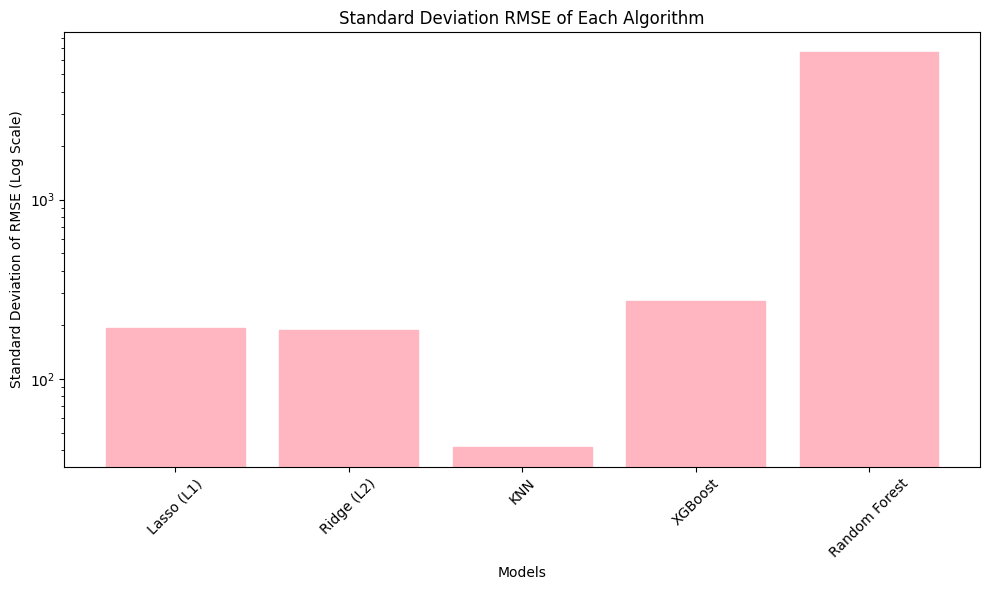

In [149]:
# RMSE data for each model and strategy
rmse_values = {
    "Lasso (L1)": [378324.7354, 378742.3667, 378720.2798],
    "Ridge (L2)": [375114.9929, 375527.5657, 375496.4197],
    "KNN": [487885.1818, 487912.4138, 487813.9329],
    "XGBoost": [342233.7962, 341989.1151, 341578.7272],
    "Random Forest": [362222.6566, 353227.5628, 369497.0136],
}

# Calculate std_rmse for each model
std_rmse = {model: np.std(values) for model, values in rmse_values.items()}
# Plotting the bar plot for std_rmse with log scale for y-axis
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(std_rmse.keys(), std_rmse.values(), color='lightpink', edgecolor='lightpink')

# Adding labels and title
ax.set_xlabel("Models")
ax.set_ylabel("Standard Deviation of RMSE (Log Scale)")
ax.set_title("Standard Deviation RMSE of Each Algorithm")
ax.set_yscale("log")  # Set y-axis to logarithmic scale
plt.xticks(rotation=45)
plt.tight_layout()

# Display plot
plt.show()


# feature importance

#### save best models

- XGBoost:

* Imputation Strategy 1: Test RMSE = 342233.7962
* Imputation Strategy 2: Test RMSE = 341989.1151
* Imputation Strategy 3: Test RMSE = 341578.7272


In [150]:
xgboost_results = results.get('XGBoost')

if xgboost_results:
    validation_scores_third_strategy = xgboost_results["Validation Scores (per imputation strategy)"][2]

    min_val_score_index = validation_scores_third_strategy.index(min(validation_scores_third_strategy))

    best_pipeline_xgboost = xgboost_results["Best Models (per imputation strategy)"][2][min_val_score_index]

    print("Best pipeline for XGBoost (third imputation strategy with lowest validation score):")
    print(best_pipeline_xgboost)
else:
    print("No results found for XGBoost.")


Best pipeline for XGBoost (third imputation strategy with lowest validation score):
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_impute',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(estimator=RandomForestRegressor(n_estimators=1,
                                                                                                                    random_state=126),
                                                                                    random_state=126)),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('rename',
                                                                   Col

In [151]:
# 假设 xgboost_best_pipeline 是你的最佳管道
best_xgboost_model = best_pipeline_xgboost.named_steps['model']

# 打印所需参数
print("reg_alpha:", best_xgboost_model.get_params().get("reg_alpha", "Not set"))
print("reg_lambda:", best_xgboost_model.get_params().get("reg_lambda", "Not set"))
print("max_depth:", best_xgboost_model.get_params().get("max_depth", "Not set"))


reg_alpha: 100.0
reg_lambda: 0.1
max_depth: 10


## 3 global feature importance

#### permutation_importance

In [152]:
best_xgboost_model = best_pipeline_xgboost.named_steps['model']
print(best_xgboost_model)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)


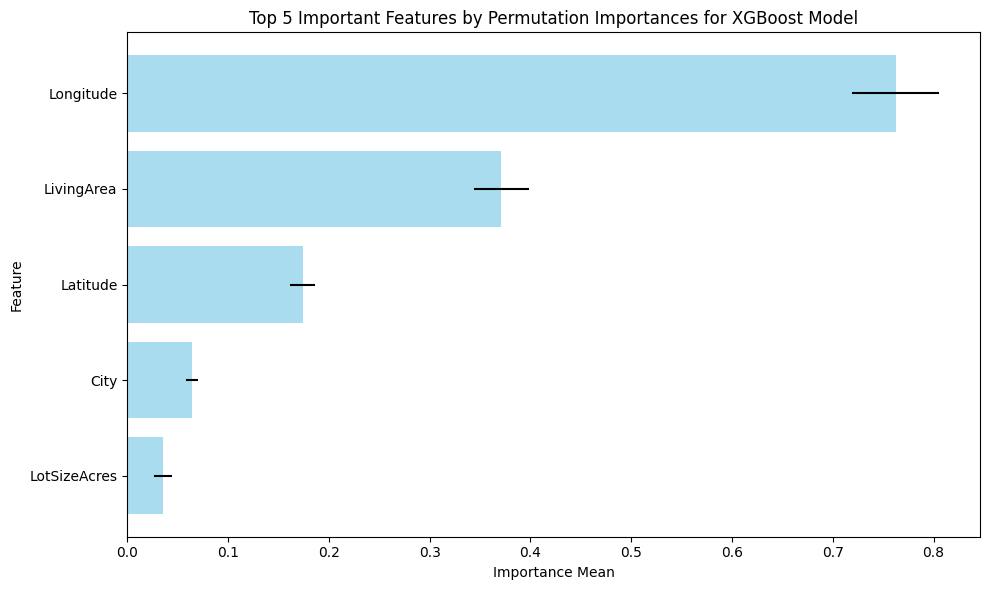

In [153]:
from sklearn.inspection import permutation_importance
result = permutation_importance(best_pipeline_xgboost, X_test, y_test, n_repeats=10, random_state=42)

importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance_Mean': result.importances_mean,
    'Importance_Std': result.importances_std
}).sort_values(by='Importance_Mean', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:5], importance_df['Importance_Mean'][:5],
         xerr=importance_df['Importance_Std'][:5], alpha=0.7, color='skyblue')
plt.gca().invert_yaxis()
plt.title(f'Top 5 Important Features by Permutation Importances for XGBoost Model')
plt.xlabel('Importance Mean')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


#### XGBOOST

Final feature names: ['LivingArea', 'LotSizeAcres', 'BathroomsTotalInteger', 'Latitude', 'Longitude', 'DaysOnMarket', 'BedroomsTotal', 'YearBuilt', 'ViewYN_False', 'ViewYN_True', 'ViewYN_unknown', 'PoolPrivateYN_False', 'PoolPrivateYN_True', 'PoolPrivateYN_unknown', 'AttachedGarageYN_No', 'AttachedGarageYN_Yes', 'AttachedGarageYN_unknown', 'BuyerAgencyCompensationType_Item', 'BuyerAgencyCompensationType_Item1', 'BuyerAgencyCompensationType_SeeRemarks', 'City_Hemet', 'City_Los Angeles', 'City_Menifee', 'City_Murrieta', 'City_Oakland', 'City_Riverside', 'City_San Diego', 'City_San Jose', 'City_Victorville', 'FireplaceYN_False', 'FireplaceYN_True', 'FireplaceYN_unknown', 'NewConstructionYN_False', 'NewConstructionYN_True', 'NewConstructionYN_unknown', 'PostalCode_90001', 'PostalCode_90002', 'PostalCode_90003', 'PostalCode_90004', 'PostalCode_90006', 'PostalCode_90007', 'PostalCode_90008', 'PostalCode_90011', 'PostalCode_90016', 'PostalCode_90018', 'PostalCode_90019', 'PostalCode_90023', '

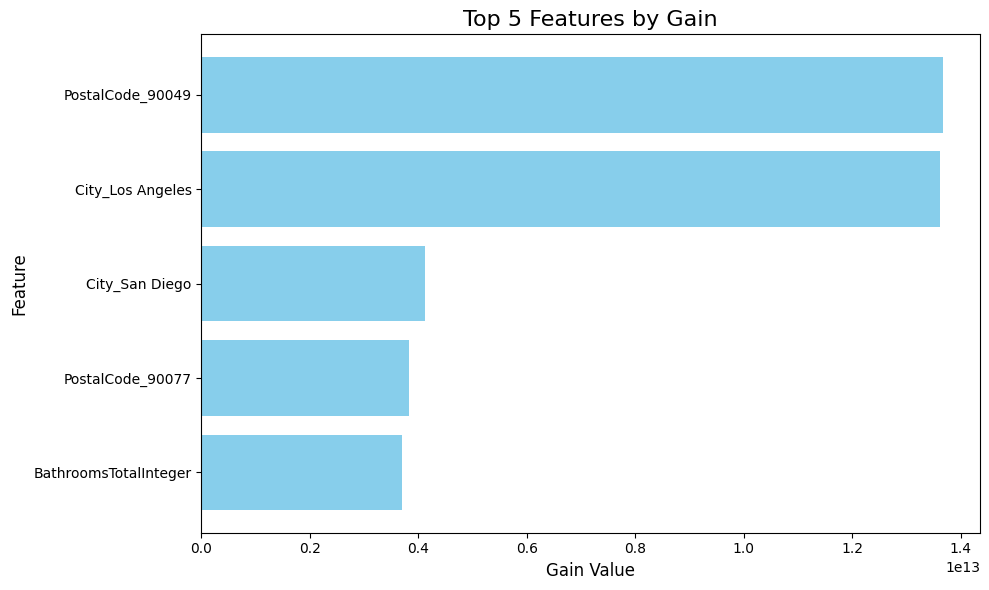

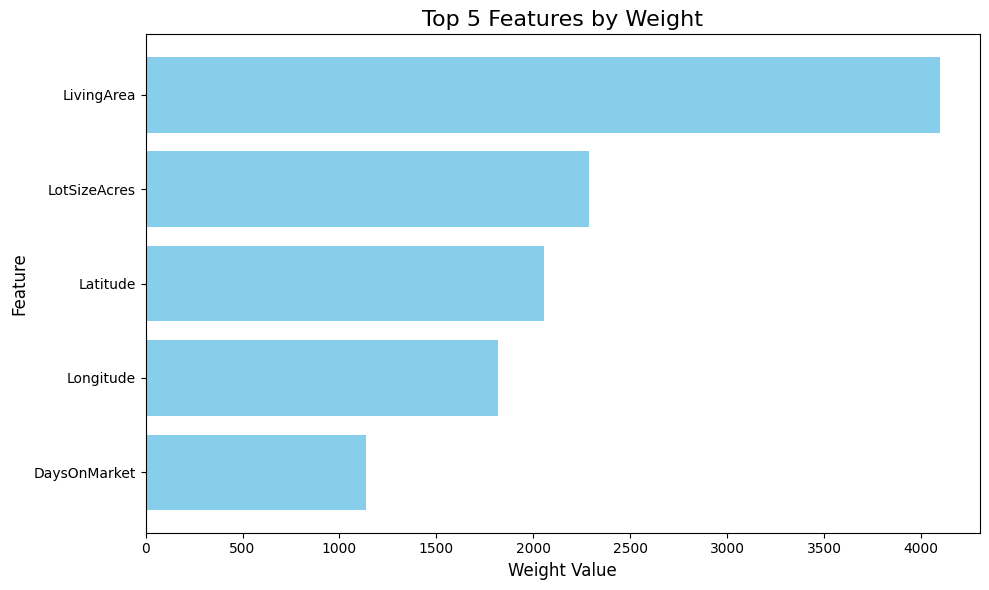

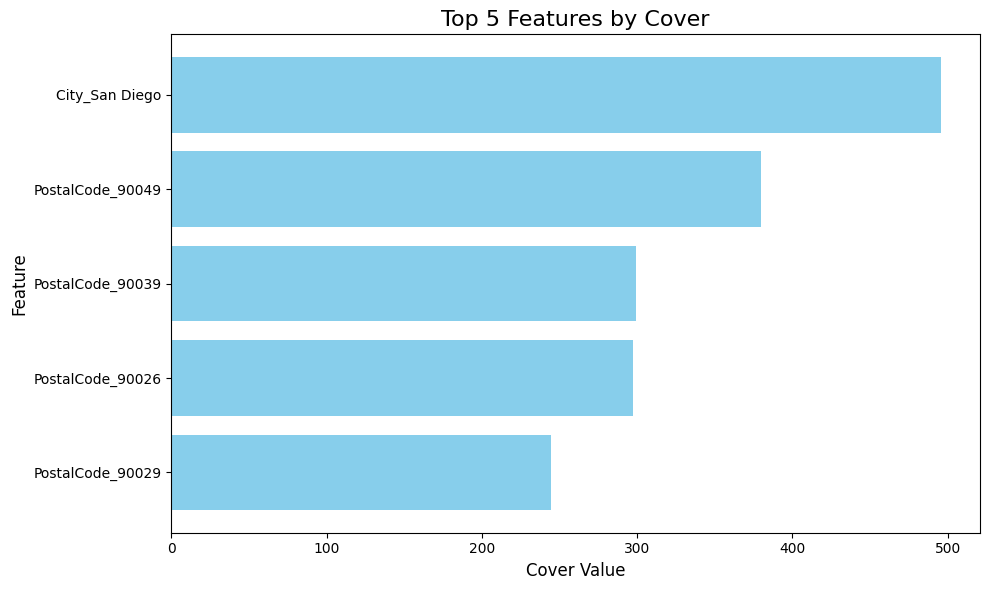

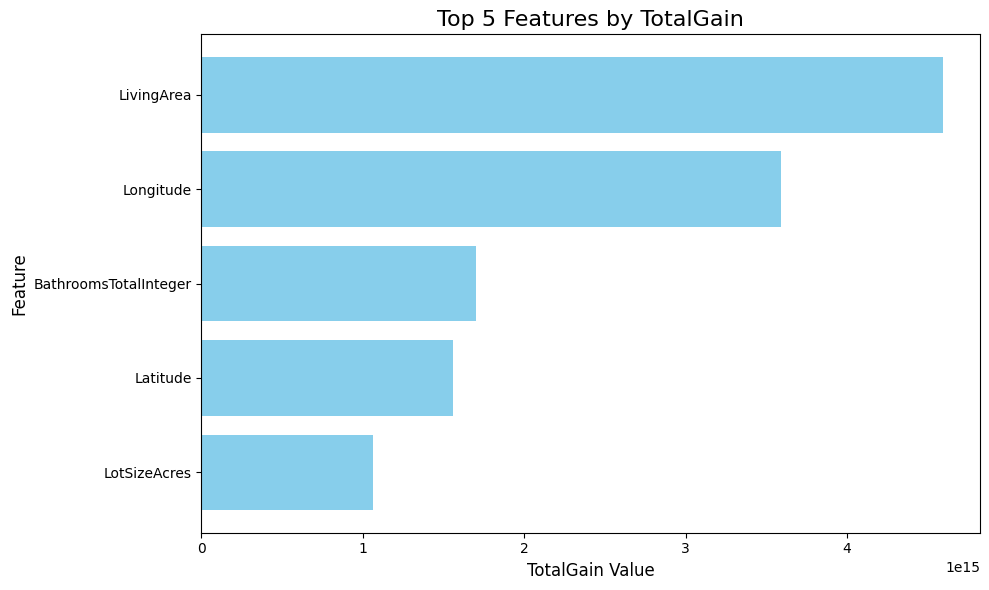

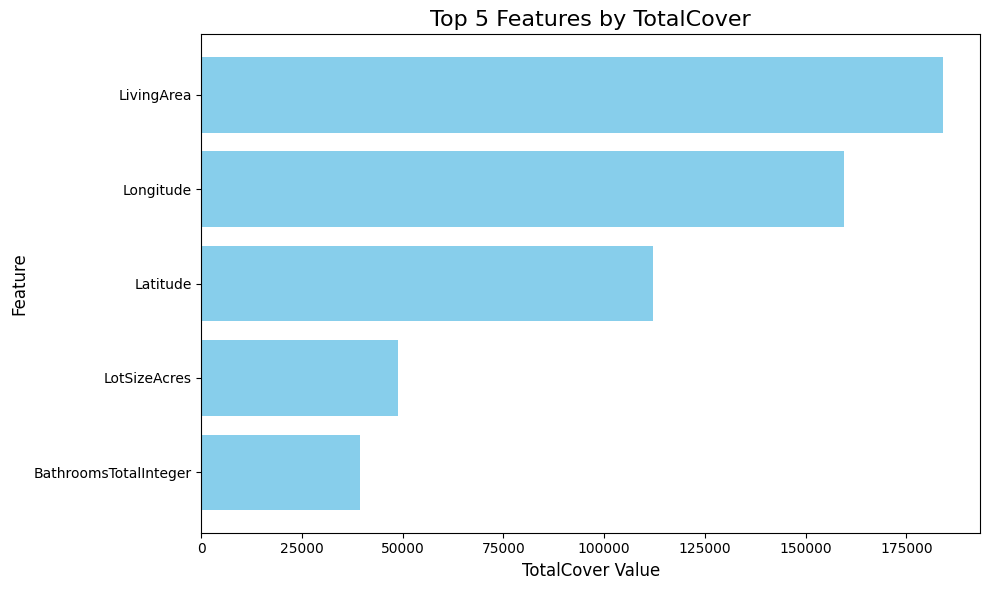

In [158]:
booster = best_xgboost_model.get_booster()
importance_metrics = {
    "Gain": booster.get_score(importance_type='gain'),
    "Weight": booster.get_score(importance_type='weight'),
    "Cover": booster.get_score(importance_type='cover'),
    "TotalGain": booster.get_score(importance_type='total_gain'),
    "TotalCover": booster.get_score(importance_type='total_cover')
}

preprocessor = best_pipeline_xgboost.named_steps['preprocessor']
final_feature_names = []

for name, transformer, cols in preprocessor.transformers_:
    if transformer == 'passthrough':
        if isinstance(cols[0], int):
            cols = [X_test.columns[i] for i in cols]
        final_feature_names.extend(cols)
    else:
        if isinstance(transformer, Pipeline):
            last_step = transformer.steps[-1][1]
        else:
            last_step = transformer

        if hasattr(last_step, 'get_feature_names_out'):
            try:
                fn = last_step.get_feature_names_out(cols)
                final_feature_names.extend(fn)
            except ValueError:
                if isinstance(cols[0], int):
                    cols = [X_test.columns[i] for i in cols]
                final_feature_names.extend(cols)
        else:
            if isinstance(cols[0], int):
                cols = [X_test.columns[i] for i in cols]
            final_feature_names.extend(cols)

aligned_metrics = {}
for metric, importance in importance_metrics.items():
    aligned_metrics[metric] = {
        final_feature_names[int(k[1:])]: v for k, v in importance.items()
    }

importance_metrics = aligned_metrics

for metric, importance in importance_metrics.items():
    df = pd.DataFrame(importance.items(), columns=['Feature', metric])
    df = df.sort_values(by=metric, ascending=False).head(5)

    plt.figure(figsize=(10, 6))
    plt.barh(df['Feature'], df[metric], color='skyblue')
    plt.gca().invert_yaxis()
    plt.title(f'Top 5 Features by {metric}', fontsize=16)
    plt.xlabel(f'{metric} Value', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

### Shape Value

SHAP values shape: (501, 186)

Top 5 important features by mean abs SHAP values for XGBoost Model:
PostalCode_90049: 602585.6875
LivingArea: 340280.7812
Longitude: 327592.7188
PostalCode_90039: 167183.4062
LotSizeAcres: 129864.7109


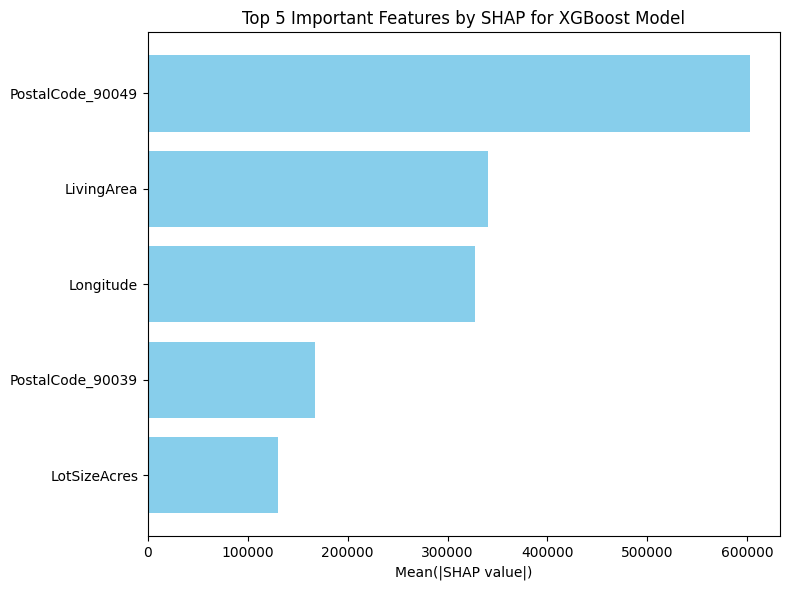

In [160]:
import shap
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

final_feature_names = []
preprocessor = best_pipeline_xgboost.named_steps['preprocessor']

for name, transformer, cols in preprocessor.transformers_:
    if transformer == 'passthrough':
        if isinstance(cols[0], int):
            cols = [X_test.columns[i] for i in cols]
        final_feature_names.extend(cols)
    else:
        if isinstance(transformer, Pipeline):
            last_step = transformer.steps[-1][1]
        else:
            last_step = transformer

        if hasattr(last_step, 'get_feature_names_out'):
            try:
                fn = last_step.get_feature_names_out(cols)
                final_feature_names.extend(fn)
            except ValueError:
                if isinstance(cols[0], int):
                    cols = [X_test.columns[i] for i in cols]
                final_feature_names.extend(cols)
        else:
            if isinstance(cols[0], int):
                cols = [X_test.columns[i] for i in cols]
            final_feature_names.extend(cols)


X_test_proc = preprocessor.transform(X_test)
if hasattr(X_test_proc, "toarray"):
    X_test_proc = X_test_proc.toarray()

explainer = shap.TreeExplainer(best_xgboost_model)
shap_values = explainer.shap_values(X_test_proc)

print("SHAP values shape:", np.array(shap_values).shape)

mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

top_indices = np.argsort(mean_abs_shap)[-5:]
top_features = np.array(final_feature_names)[top_indices]
top_importances = mean_abs_shap[top_indices]

print("\nTop 5 important features by mean abs SHAP values for XGBoost Model:")
for f, val in sorted(zip(top_features, top_importances), key=lambda x: x[1], reverse=True):
    print(f"{f}: {val:.4f}")

plt.figure(figsize=(8, 6))
y_pos = np.arange(len(top_features))
sorted_importances = sorted(top_importances, reverse=True)
sorted_features = [f for f, val in sorted(zip(top_features, top_importances), key=lambda x: x[1], reverse=True)]
plt.barh(y_pos, sorted_importances, align='center', color='skyblue')
plt.yticks(y_pos, sorted_features)
plt.gca().invert_yaxis()
plt.title("Top 5 Important Features by SHAP for XGBoost Model")
plt.xlabel("Mean(|SHAP value|)")
plt.tight_layout()
plt.show()

## local feature importance

In [161]:

shap.initjs()

instance_index = 17
shap_values_instance = shap_values[instance_index]
X_instance = X_test_proc[instance_index]

# Create the force plot
shap.force_plot(
    explainer.expected_value,
    shap_values_instance,
    X_instance,
    feature_names=final_feature_names
)
